In [1]:
%load_ext autoreload
%autoreload 2

In [137]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
import importlib
import eda_helper_functions
importlib.reload(eda_helper_functions)

from sklearn.ensemble import IsolationForest

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)

## 1. Load Data

In [ ]:
df = pd.read_csv('data/raw/cleaned_dataV2.csv')

In [4]:
df.head()

localityname  \
0  sector 108, noida express way   
1                      sector 76   
2                     sector 118   
3                      sector 29   
4          sector 49, dadri road   

                                           landmarks    locality       price  \
0  well developed area with all facilities near s...  sector 108 17325000.00   
1     450 meters from metro station.facing main road   sector 76 15000000.00   
2                                                NaN  sector 118  3950000.00   
3                           near brahmaputra market.   sector 29 25000000.00   
4                                                NaN   sector 49  4300000.00   

   superbuiltupareasqft          nameofsociety            projectname  \
0               3850.00          parx laureate          Parx Laureate   
1               1180.00  amrapali silicon city  Amrapali Silicon City   
2               1005.00                    NaN                    NaN   
3               1800.00  brahmaputra apartment  Brahmaputra Apartment   
4               1050.00   project hindon vihar   Project Hindon Vihar   

  possessionstatus floornumber  totalfloornumber  ...  \
0    ready to move           7             18.00  ...   
1    ready to move           9             13.00  ...   
2    ready to move         NaN               NaN  ...   
3    ready to move           1              3.00  ...   
4    ready to move           1              4.00  ...   

              propertytype                        additionalrooms  \
0    multistorey apartment         puja room, store, servant room   
1    multistorey apartment                                  study   
2    multistorey apartment                                    NaN   
3    multistorey apartment  puja room, study, store, servant room   
4  builder floor apartment                              puja room   

           ageofcons                                  propertyamenities  \
0                NaN  {'12201': 'Power Back Up', '12202': 'Lift', '1...   
1  less than 5 years  {'12202': 'Lift', '12203': 'Rain Water Harvest...   
2                NaN                                                NaN   
3     15 to 20 years  {'12203': 'Rain Water Harvesting', '12204': 'C...   
4                NaN  {'12213': 'Vaastu Compliant', '12215': 'Air Co...   

                                      facilitiesdesc propertyid  \
0  Power Back Up, Lift, Rain Water Harvesting, Cl...   10446116   
1  Lift, Rain Water Harvesting, Club House, Park,...   10714088   
2                                                NaN   11361681   
3  Rain Water Harvesting, Club House, Swimming Po...   11376982   
4  Vaastu Compliant, Air Conditioned, Visitor Par...   12494130   

                                                 url  region  price_log  \
0  https://www.magicbricks.com/propertyDetails/4-...   noida       2.85   
1  https://www.magicbricks.com/propertyDetails/2-...   noida       2.71   
2  https://www.magicbricks.com/propertyDetails/2-...   noida       1.37   
3  https://www.magicbricks.com/propertyDetails/3-...   noida       3.22   
4  https://www.magicbricks.com/propertyDetails/3-...   noida       1.46   

  superbuiltupareasqft_log  
0                     8.26  
1                     7.07  
2                     6.91  
3                     7.50  
4                     6.96  

[5 rows x 29 columns]

## 2. Preliminary Analysis

In [5]:
## Check for Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53969 entries, 0 to 53968
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   localityname              52788 non-null  object 
 1   landmarks                 33451 non-null  object 
 2   locality                  52883 non-null  object 
 3   price                     53969 non-null  float64
 4   superbuiltupareasqft      53969 non-null  float64
 5   nameofsociety             35380 non-null  object 
 6   projectname               35356 non-null  object 
 7   possessionstatus          44258 non-null  object 
 8   floornumber               44244 non-null  object 
 9   totalfloornumber          47949 non-null  float64
 10  longitude                 52894 non-null  float64
 11  latitude                  52894 non-null  float64
 12  transactiontype           53965 non-null  object 
 13  facing                    37946 non-null  object 
 14  owners

In [6]:
# number of rows in the data that have missing values

missing_rows = (
    df.isnull().any(axis=1).sum()
    )


print(f'There are {missing_rows} rows with missing values in the data.')

print(f"It accounts for {(missing_rows/df.shape[0])*100:.2f}% of the data")

There are 38972 rows with missing values in the data.
It accounts for 72.21% of the data


- Inconsistent NaN value present in the dataset that's why it accounts for 72.23%. we have to perform imputation and removing some unimportant features.

In [7]:
num_cols = [col for col in df.columns if df[col].dtype != 'object']
cat_cols = [col for col in df.columns if df[col].dtype == 'object'] 

print(f"Number of numerical columns: {len(num_cols)}")
print(f"Number of categorical columns: {len(cat_cols)}")

Number of numerical columns: 11
Number of categorical columns: 18


In [8]:
## Check for descriptive statistics


df.describe(include='number').T

count        mean         std        min  \
price                    53969.00 35145564.85 39772809.09 3000000.00   
superbuiltupareasqft     53969.00     2025.19     1151.59     452.00   
totalfloornumber         47949.00       11.91       10.52       1.00   
longitude                52894.00       77.19        0.47      28.63   
latitude                 52894.00       28.51        0.32      17.55   
bedrooms                 53824.00        3.15        0.98       1.00   
bathrooms                53801.00        3.09        1.16       1.00   
numberofbalconied        47707.00        2.78        1.13       1.00   
propertyid               53969.00 76844651.80  9617016.32 1095807.00   
price_log                53969.00        3.16        0.89       1.10   
superbuiltupareasqft_log 53969.00        7.48        0.50       6.12   

                                 25%         50%         75%          max  
price                    13300000.00 24500000.00 41364000.00 500000000.00  
superbuiltupareasqft         1291.67     1800.00     2400.00     18900.00  
totalfloornumber                4.00        5.00       20.00        68.00  
longitude                      77.05       77.11       77.37        88.39  
latitude                       28.42       28.52       28.59        77.17  
bedrooms                        3.00        3.00        4.00        10.00  
bathrooms                       2.00        3.00        4.00        10.00  
numberofbalconied               2.00        3.00        3.00        10.00  
propertyid               77287527.00 80325283.00 81281763.00  81677635.00  
price_log                       2.59        3.20        3.72         6.21  
superbuiltupareasqft_log        7.16        7.50        7.78         9.85

In [9]:
# Check for missing values
df.isnull().sum()

localityname                 1181
landmarks                   20518
locality                     1086
price                           0
superbuiltupareasqft            0
nameofsociety               18589
projectname                 18613
possessionstatus             9711
floornumber                  9725
totalfloornumber             6020
longitude                    1075
latitude                     1075
transactiontype                 4
facing                      16023
ownershiptype               14682
furnished                     790
bedrooms                      145
bathrooms                     168
numberofbalconied            6262
propertytype                    0
additionalrooms             20093
ageofcons                    6373
propertyamenities           13877
facilitiesdesc              13877
propertyid                      0
url                             5
region                          0
price_log                       0
superbuiltupareasqft_log        0
dtype: int64

In [10]:
## check for duplicated values
df.duplicated().sum()

np.int64(0)

In [11]:
# statistical summary of categorical columns

(
   df.describe(include='object').T
)

count unique  \
localityname       52788   2307   
landmarks          33451  17237   
locality           52883   2248   
nameofsociety      35380   3533   
projectname        35356   3147   
possessionstatus   44258      2   
floornumber        44244     46   
transactiontype    53965      2   
facing             37946     10   
ownershiptype      39287      4   
furnished          53179      3   
propertytype       53969      5   
additionalrooms    33876     63   
ageofcons          47596      7   
propertyamenities  40092  22042   
facilitiesdesc     40092  22042   
url                53964  53964   
region             53969      4   

                                                                 top   freq  
localityname                                         noida extension   3695  
landmarks                                          dwarka expressway    265  
locality                                             noida extension   3712  
nameofsociety                             m3m antalya hills phase ii    271  
projectname                               M3M Antalya Hills Phase II    271  
possessionstatus                                       ready to move  43990  
floornumber                                                        1   6942  
transactiontype                                               resale  34892  
facing                                                  north - east  17150  
ownershiptype                                               freehold  29433  
furnished                                             semi-furnished  33037  
propertytype                                   multistorey apartment  34847  
additionalrooms                                         servant room   6968  
ageofcons                                           new construction  13558  
propertyamenities  {'12201': 'Power Back Up', '12202': 'Lift', '1...   1534  
facilitiesdesc     Power Back Up, Lift, Rain Water Harvesting, Cl...   1534  
url                https://www.magicbricks.com/propertyDetails/2-...      1  
region                                                       gurgaon  21434

## 3. Checking Missing Values

In [12]:
eda_helper_functions.missing_info(df)

count  percentage
variable                            
landmarks          20518       38.02
additionalrooms    20093       37.23
projectname        18613       34.49
nameofsociety      18589       34.44
facing             16023       29.69
ownershiptype      14682       27.20
facilitiesdesc     13877       25.71
propertyamenities  13877       25.71
floornumber         9725       18.02
possessionstatus    9711       17.99
ageofcons           6373       11.81
numberofbalconied   6262       11.60
totalfloornumber    6020       11.15
localityname        1181        2.19
locality            1086        2.01
latitude            1075        1.99
longitude           1075        1.99
furnished            790        1.46
bathrooms            168        0.31
bedrooms             145        0.27
url                    5        0.01
transactiontype        4        0.01

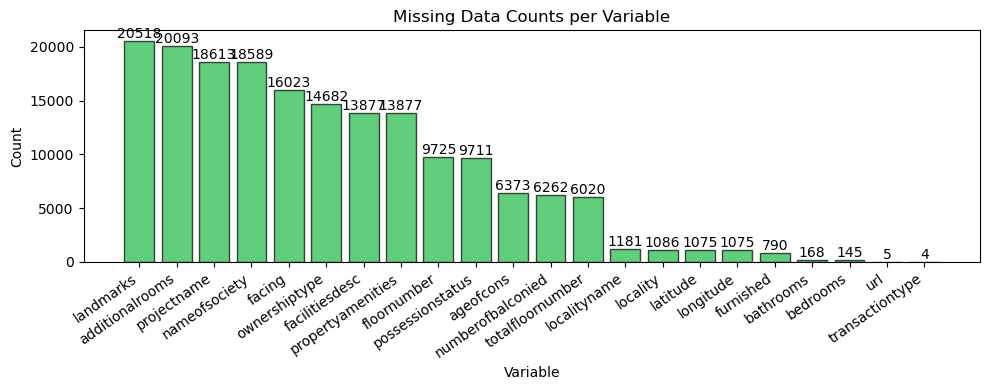

In [13]:
eda_helper_functions.plot_missing_info(df)

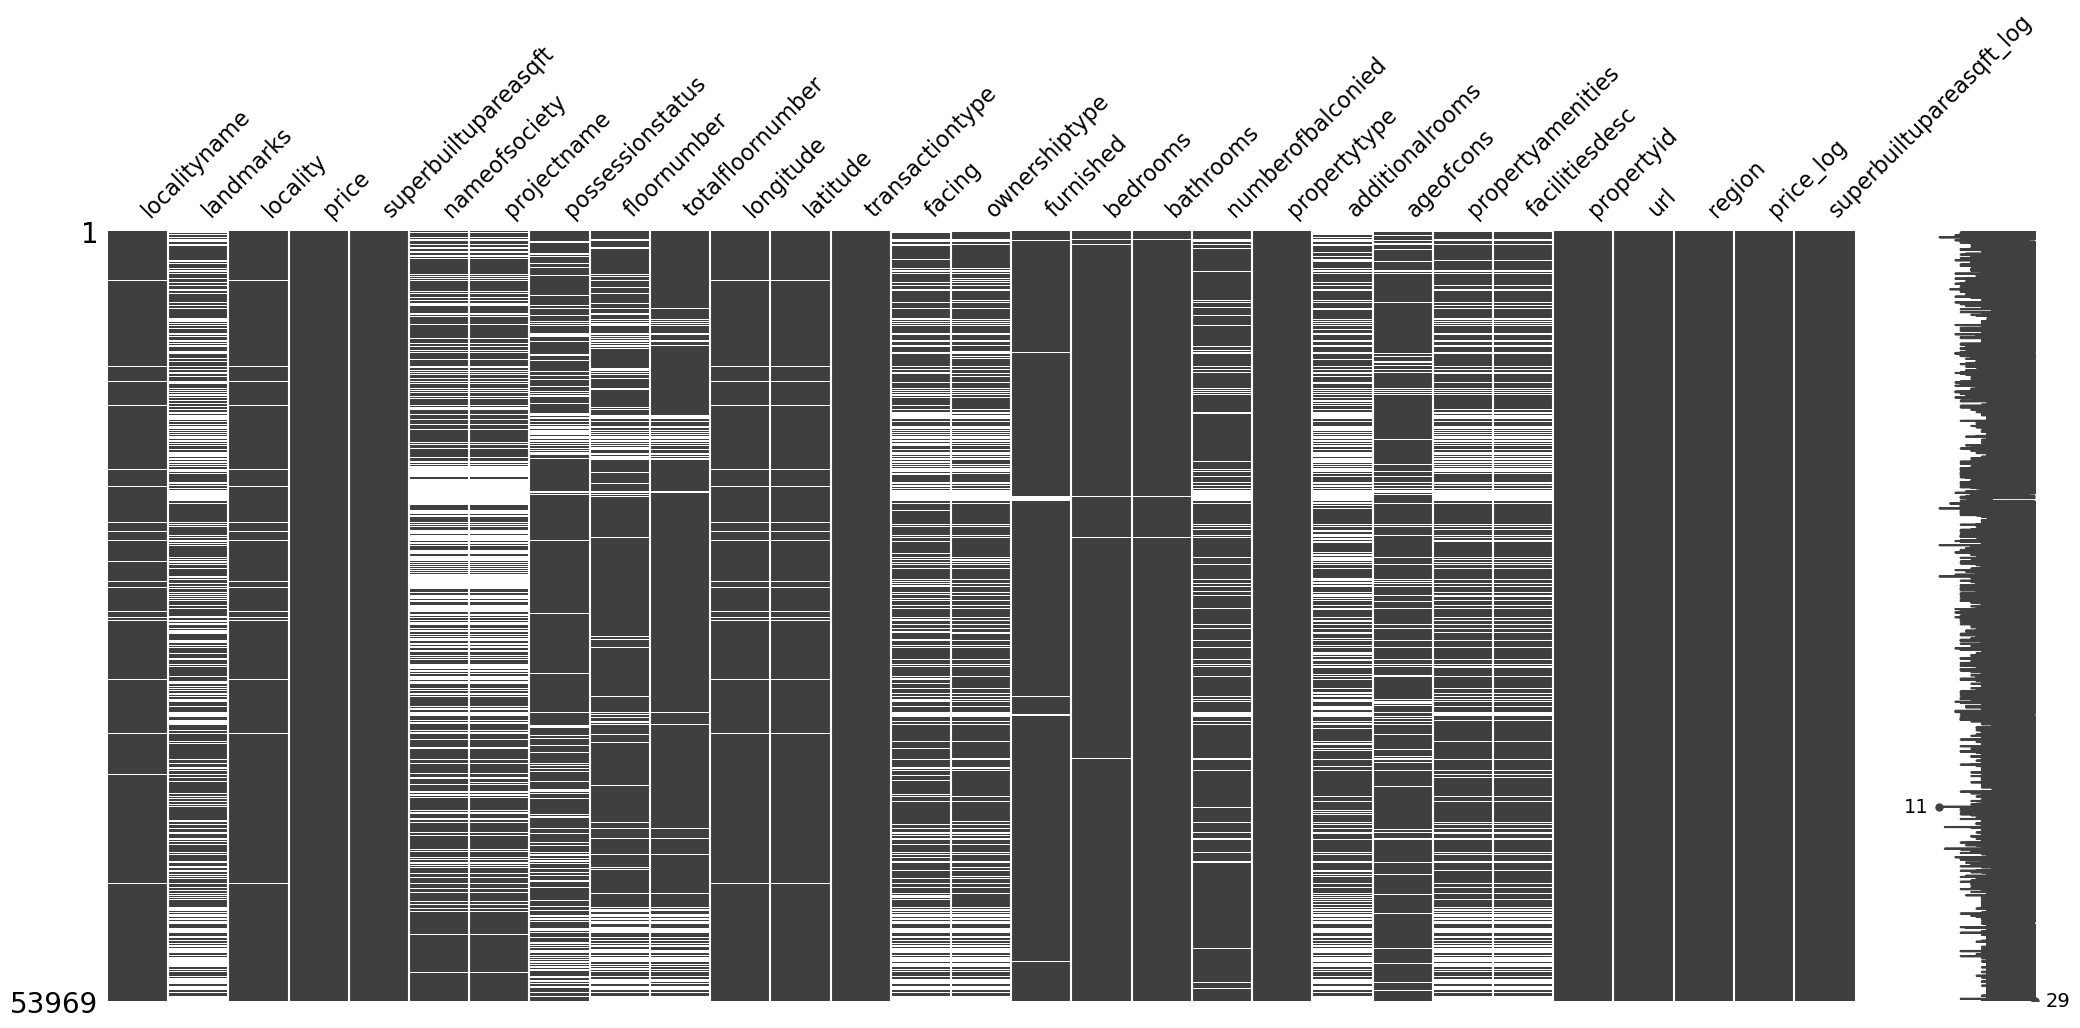

In [14]:
import missingno as msno


msno.matrix(df)
plt.show()

In [15]:
#a dendrogram to show correlations between missing values.
msno.dendrogram(df) #clusters columns based on how their missing values are related.

<Axes: >

## 4. High-level analysis of Outliers

In [16]:
forest = IsolationForest(n_estimators=10,random_state=42)

In [17]:
(
    df.assign(
        outliers=forest.fit_predict(
            df.drop(columns='price')
            .select_dtypes(include='number')
        )
    ).query('outliers==-1')
)

localityname  \
0      sector 108, noida express way   
1                          sector 76   
2                         sector 118   
3                          sector 29   
4              sector 49, dadri road   
...                              ...   
53964                     sohna road   
53965                      sector 49   
53966               golf course road   
53967                     sohna road   
53968                      sector 14   

                                               landmarks          locality  \
0      well developed area with all facilities near s...        sector 108   
1         450 meters from metro station.facing main road         sector 76   
2                                                    NaN        sector 118   
3                               near brahmaputra market.         sector 29   
4                                                    NaN         sector 49   
...                                                  ...               ...   
53964  sector 68, sohna road, next to badshahpur, era...        sohna road   
53965  just 1.5 km from nh8 and 1.5 km from proposed ...         sector 49   
53966                                                NaN  golf course road   
53967  just off sohna road and minutes away from the ...        sohna road   
53968                                                NaN         sector 14   

            price  superbuiltupareasqft          nameofsociety  \
0     17325000.00               3850.00          parx laureate   
1     15000000.00               1180.00  amrapali silicon city   
2      3950000.00               1005.00                    NaN   
3     25000000.00               1800.00  brahmaputra apartment   
4      4300000.00               1050.00   project hindon vihar   
...           ...                   ...                    ...   
53964  5378000.00               1582.00                    NaN   
53965  5399100.00               1714.00            vatika city   
53966 80000000.00               7000.00                    NaN   
53967 76000000.00               6869.00                    NaN   
53968  6500000.00               1255.00                    NaN   

                 projectname possessionstatus floornumber  totalfloornumber  \
0              Parx Laureate    ready to move           7             18.00   
1      Amrapali Silicon City    ready to move           9             13.00   
2                        NaN    ready to move         NaN               NaN   
3      Brahmaputra Apartment    ready to move           1              3.00   
4       Project Hindon Vihar    ready to move           1              4.00   
...                      ...              ...         ...               ...   
53964                    NaN              NaN           7             11.00   
53965            Vatika City              NaN           8             14.00   
53966                    NaN    ready to move         NaN               NaN   
53967                    NaN              NaN         NaN               NaN   
53968                    NaN    ready to move           1              3.00   

       ...                        additionalrooms           ageofcons  \
0      ...         puja room, store, servant room                 NaN   
1      ...                                  study   less than 5 years   
2      ...                                    NaN                 NaN   
3      ...  puja room, study, store, servant room      15 to 20 years   
4      ...                              puja room                 NaN   
...    ...                                    ...                 ...   
53964  ...                                    NaN  under construction   
53965  ...                                    NaN  under construction   
53966  ...                                    NaN                 NaN   
53967  ...                           servant room  under construction   
53968  ...                                    NaN            

## 5. Pair Plots

In [18]:
eda_helper_functions.pair_plots(df)

## 6. Correlation

In [19]:
eda_helper_functions.correlation_heatmap(df)

##### According to Spearman correlation:
- `superbuiltupareasqft` and `bedrooms` are moderately correlated.
- `superbuiltupareasqft` with `price` and `bathrooms` are higly correlated.
- `price` with `bedrooms` and `bathrooms` are moderately correlated.

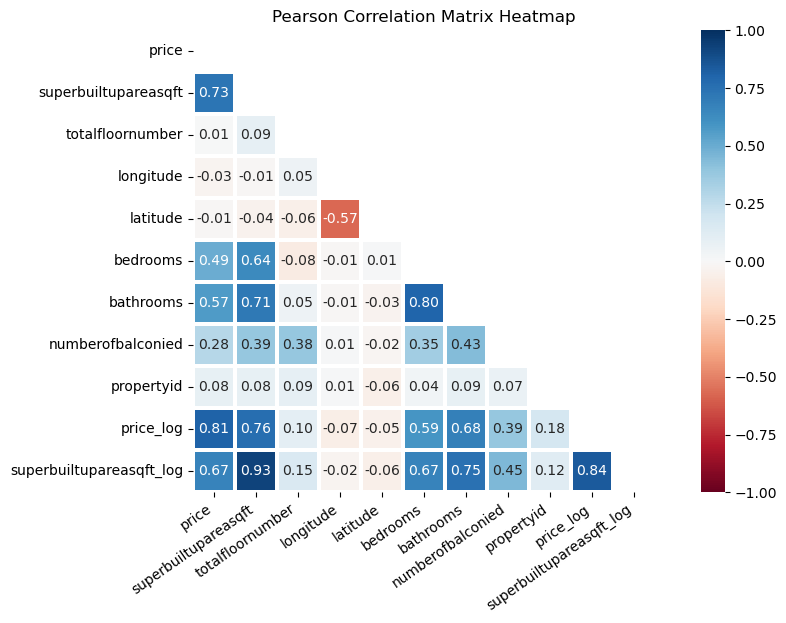

In [20]:
eda_helper_functions.correlation_heatmap(df, method='pearson')

## 7. Detailed Analysis of each feature

In [21]:
df.columns

Index(['localityname', 'landmarks', 'locality', 'price',
       'superbuiltupareasqft', 'nameofsociety', 'projectname',
       'possessionstatus', 'floornumber', 'totalfloornumber', 'longitude',
       'latitude', 'transactiontype', 'facing', 'ownershiptype', 'furnished',
       'bedrooms', 'bathrooms', 'numberofbalconied', 'propertytype',
       'additionalrooms', 'ageofcons', 'propertyamenities', 'facilitiesdesc',
       'propertyid', 'url', 'region', 'price_log', 'superbuiltupareasqft_log'],
      dtype='object')

### 7.1 locality

In [22]:
df.locality

0              sector 108
1               sector 76
2              sector 118
3               sector 29
4               sector 49
               ...       
53964          sohna road
53965           sector 49
53966    golf course road
53967          sohna road
53968           sector 14
Name: locality, Length: 53969, dtype: object

In [23]:
eda_helper_functions.cat_summary(df, 'locality')

0              sector 108
1               sector 76
2              sector 118
3               sector 29
4               sector 49
               ...       
53964          sohna road
53965           sector 49
53966    golf course road
53967          sohna road
53968           sector 14
Name: locality, Length: 53969, dtype: object

Data Type      : object
Cardinality    : 2248 categories
Missing Data   : 1,086 rows (2.01 %)
Available Data : 52,883 / 53,969 rows


count             52883
unique             2248
top     noida extension
freq               3712

count  percentage
category                                                         
noida extension                                  3712        0.07
sector 113                                        723        0.01
sector 79                                         692        0.01
sector 89                                         633        0.01
sector 102                                        564        0.01
yamuna expressway                                 541        0.01
sector 150                                        498        0.01
sector 65                                         491        0.01
sector 107                                        456        0.01
sector 76                                         447        0.01
gk i                                              428        0.01
sector 63a                                        413        0.01
sector 104                                        413        0.01
sector 111                                        407        0.01
sector 1                                          405        0.01
sector 6 dwarka                                   393        0.01
sector 106                                        390        0.01
sector 67a                                        364        0.01
sector 10 dwarka                                  353        0.01
sector 36 sohna                                   342        0.01
sector 128                                        342        0.01
sector 12                                         327        0.01
sector 59                                         325        0.01
techzone 4                                        318        0.01
sector 92                                         317        0.01
sector 12 dwarka                                  311        0.01
sector 4 dwarka                                   304        0.01
dlf phase 2                                       302        0.01
gk ii                                             300        0.01
sector 137                                        299        0.01
sector 48                                         296        0.01
sector 49                                         296        0.01
sector 103                                        292        0.01
dwarka                                            288        0.01
sushant lok 1                                     288        0.01
sector 66                                         285        0.01
sector 19 dwarka                                  284        0.01
sector 108                                        282        0.01
dlf phase 1                                       271        0.01
sector 93                                         266        0.01
sector 78                                         265        0.01
sector 62                                         264        0.00
sector 37d                                        256        0.00
sohna                                             256        0.00
sector 70                                         256        0.00
sector 75                                         256        0.00
sector 5 dwarka                                   248        0.00
sector 22 dwarka                                  248        0.00
nirvana country                                   239        0.00
sector 32 sohna                                   229        0.00
chi 5                                             226        0.00
sector 54                                         226        0.00
sector 69                                         226        0.00
sector 77                                         225        0.00
sector 115                                        225        0.00
sector 11 dwarka                                  225        0.00
sector 112                                        224        0.00
sector 61                                         224        0.00
safdarjung enclave                                223        0.00
dlf phase 5           

### 7.2 price

#### before log transformation

In [24]:
eda_helper_functions.num_summary(df, 'price')

0       17325000.00
1       15000000.00
2        3950000.00
3       25000000.00
4        4300000.00
            ...    
53964    5378000.00
53965    5399100.00
53966   80000000.00
53967   76000000.00
53968    6500000.00
Name: price, Length: 53969, dtype: float64

Data Type      : float64
Missing Data   : 0 rows (0.00 %)
Available Data : 53,969 / 53,969 rows


value
percentile             
0            3000000.00
5            5000000.00
10           7000000.00
25          13300000.00
50          24500000.00
75          41364000.00
90          72500000.00
95         100000000.00
99         200000000.00
100        500000000.00

value
mean               35145564.85
trimmed mean (5%)  29624219.29
trimmed mean (10%) 27659855.41
median             24500000.00

value
var           1581876342704127.50
std                   39772809.09
IQR                   28064000.00
mad                   13000000.00
coef_variance                1.13

value
skewness   4.09
kurtosis  25.96

Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 3.7173982807485156e-134
Test Statistic       : 0.637933300714431
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 4512.574251414218
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


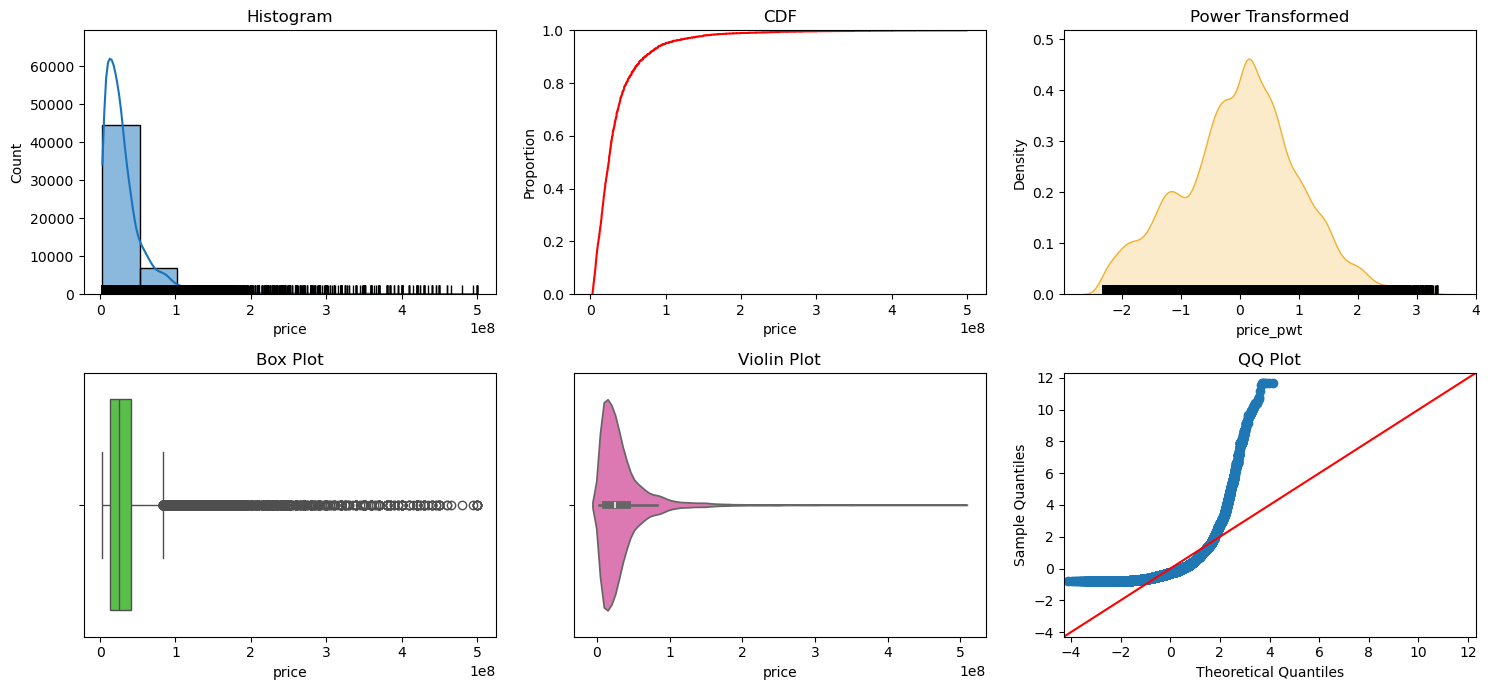

In [25]:
eda_helper_functions.num_univar_plots(df, 'price')

#### after log transformation

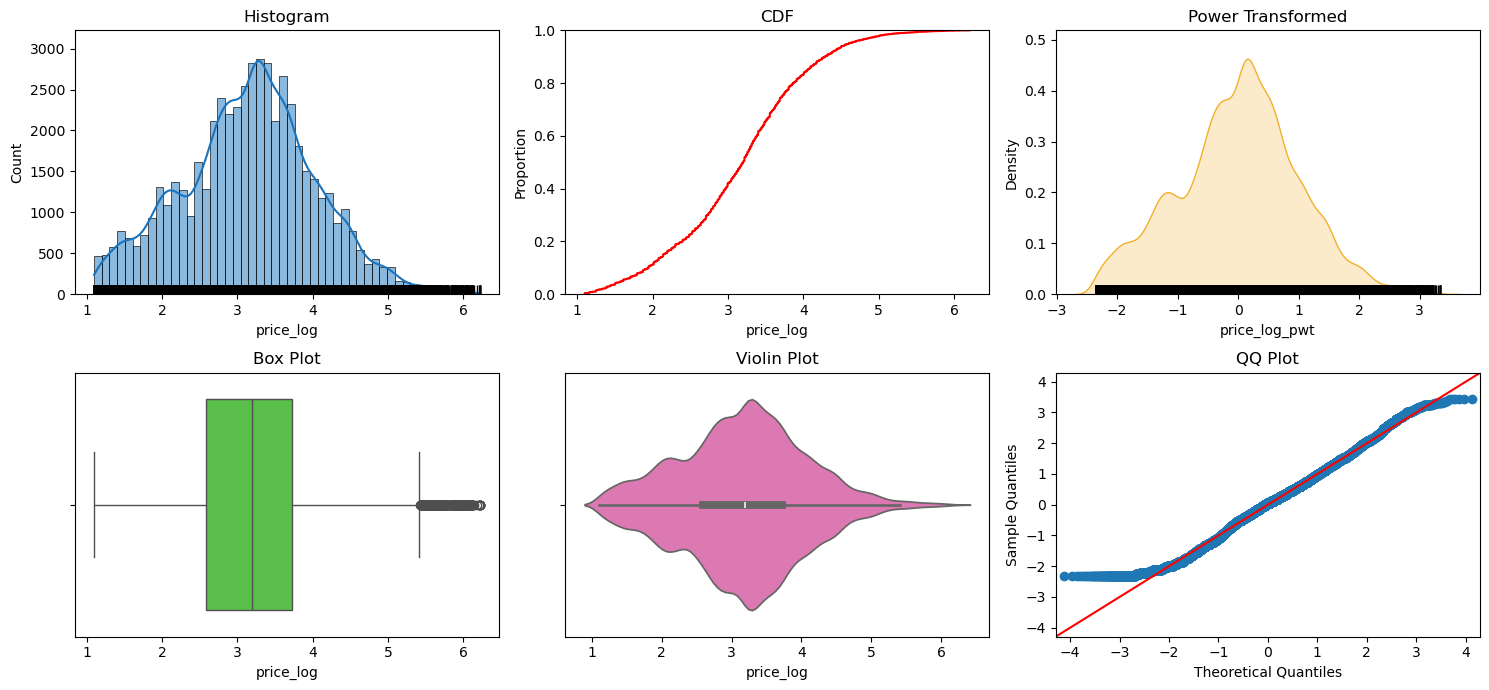

In [26]:
eda_helper_functions.num_univar_plots(df, 'price_log', bins=50)

##### observations:
1. The target columns(price) follows an slightly  bimodal distribution  after apply log transformation.
2. The target column has some extreme points which can be considered as outliers but they are just extreme and rare,not outliers. They hold significance.

### superbuiltupareasqft

#### before log transformation

In [27]:
eda_helper_functions.num_summary(df, 'superbuiltupareasqft')

0       3850.00
1       1180.00
2       1005.00
3       1800.00
4       1050.00
          ...  
53964   1582.00
53965   1714.00
53966   7000.00
53967   6869.00
53968   1255.00
Name: superbuiltupareasqft, Length: 53969, dtype: float64

Data Type      : float64
Missing Data   : 0 rows (0.00 %)
Available Data : 53,969 / 53,969 rows


value
percentile         
0            452.00
5            766.40
10           950.00
25          1291.67
50          1800.00
75          2400.00
90          3392.00
95          4325.40
99          6500.00
100        18900.00

value
mean               2025.19
trimmed mean (5%)  1906.23
trimmed mean (10%) 1854.33
median             1800.00

value
var           1326155.67
std              1151.59
IQR              1108.33
mad               550.00
coef_variance       0.57

value
skewness   2.24
kurtosis   8.74

Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 3.7993176518721505e-113
Test Statistic       : 0.8267110616912307
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 2017.3230427682865
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


In [28]:
eda_helper_functions.num_univar_plots(df, 'superbuiltupareasqft', bins=50)

#### After log transformation

In [29]:
df['superbuiltupareasqft_log'] = np.log1p(df['superbuiltupareasqft'])

In [30]:
eda_helper_functions.num_summary(df, 'superbuiltupareasqft_log')

0       8.26
1       7.07
2       6.91
3       7.50
4       6.96
        ... 
53964   7.37
53965   7.45
53966   8.85
53967   8.83
53968   7.14
Name: superbuiltupareasqft_log, Length: 53969, dtype: float64

Data Type      : float64
Missing Data   : 0 rows (0.00 %)
Available Data : 53,969 / 53,969 rows


value
percentile       
0            6.12
5            6.64
10           6.86
25           7.16
50           7.50
75           7.78
90           8.13
95           8.37
99           8.78
100          9.85

value
mean                 7.48
trimmed mean (5%)    7.48
trimmed mean (10%)   7.48
median               7.50

value
var             0.25
std             0.50
IQR             0.62
mad             0.31
coef_variance   0.07

value
skewness   0.16
kurtosis   0.28

Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 1.0587700652546508e-36
Test Statistic       : 0.9952275476935282
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 71.12806204699154
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


In [31]:
eda_helper_functions.num_univar_plots(df, 'superbuiltupareasqft_log', bins=50)

#### observations:
1. The superbuiltupareasqft follows a slightly normal distribution after log transformation.
2. There are extreme values that can be considered outliers, and a few of these outliers hold no significane in the dataset because they are incorrect.Therefore, will drops the incorrect values while building model.

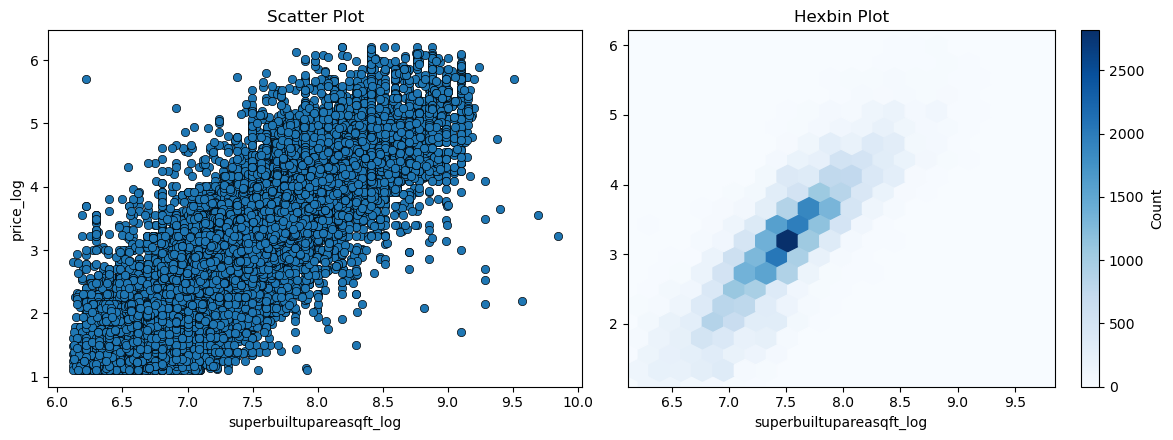

In [85]:
eda_helper_functions.num_bivar_plots(
                                    df,
                                    'superbuiltupareasqft_log',
                                    'price_log',
                                     hexbin_kwargs=dict(
                                         gridsize=20,
                                         cmap='Blues'
                                     ))   

In [84]:
eda_helper_functions.num_num_hyp_testing(df, 'price_log', 'superbuiltupareasqft_log')

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.8360164445170115
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price_log and superbuiltupareasqft_log are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.8472948645739039
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price_log and superbuiltupareasqft_log are correlated


### 7.3 possessionstatus

In [32]:
eda_helper_functions.cat_summary(df, 'possessionstatus')

0        ready to move
1        ready to move
2        ready to move
3        ready to move
4        ready to move
             ...      
53964              NaN
53965              NaN
53966    ready to move
53967              NaN
53968    ready to move
Name: possessionstatus, Length: 53969, dtype: object

Data Type      : object
Cardinality    : 2 categories
Missing Data   : 9,711 rows (17.99 %)
Available Data : 44,258 / 53,969 rows


count           44258
unique              2
top     ready to move
freq            43990

count  percentage
category                             
ready to move       43990        0.99
under construction    268        0.01

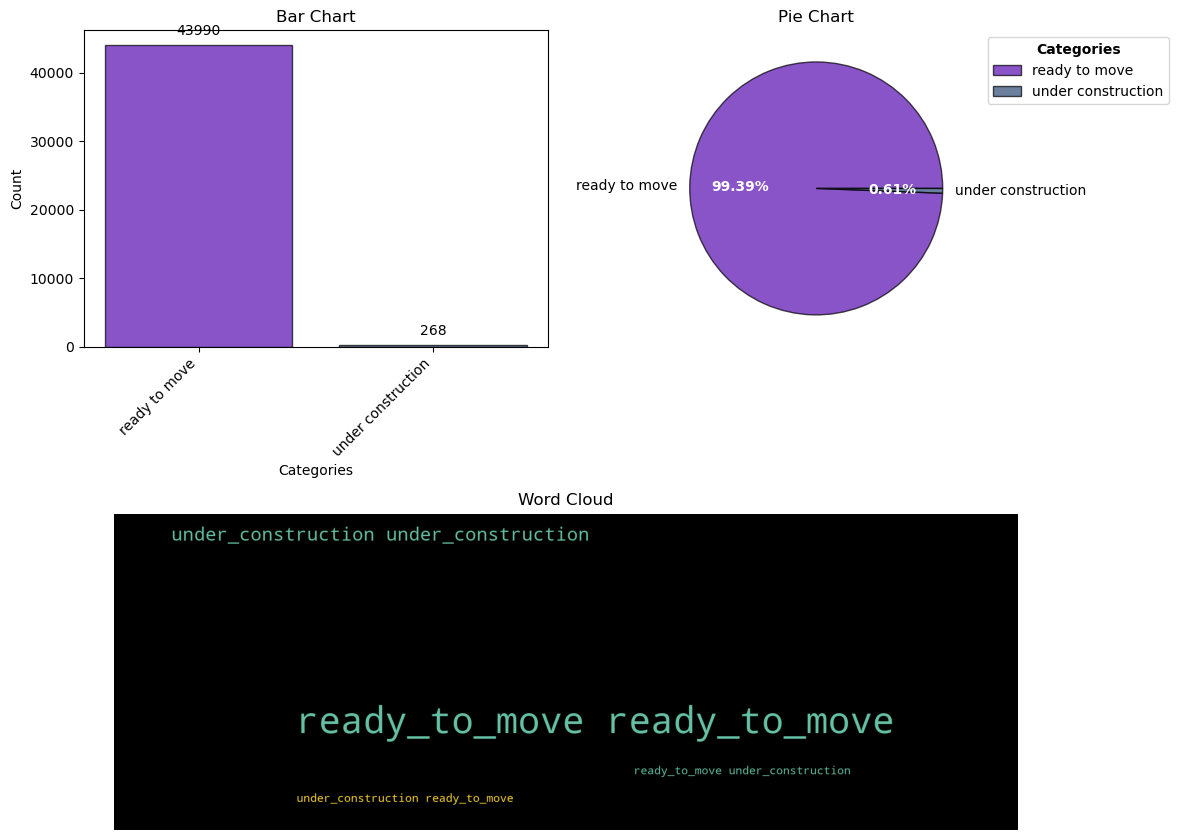

In [33]:
eda_helper_functions.cat_univar_plots(df, 'possessionstatus')

#### observations:
- The possessionstatus columns has three unique values such as `ready to move`, `under construction`, and `immediately`.But ready to move holds 99.37% of values in possessionstatus columns. This column is imbalanced which can lead to low variablility, risk of overfitting, and encoding issue.

In [34]:
df.columns

Index(['localityname', 'landmarks', 'locality', 'price',
       'superbuiltupareasqft', 'nameofsociety', 'projectname',
       'possessionstatus', 'floornumber', 'totalfloornumber', 'longitude',
       'latitude', 'transactiontype', 'facing', 'ownershiptype', 'furnished',
       'bedrooms', 'bathrooms', 'numberofbalconied', 'propertytype',
       'additionalrooms', 'ageofcons', 'propertyamenities', 'facilitiesdesc',
       'propertyid', 'url', 'region', 'price_log', 'superbuiltupareasqft_log'],
      dtype='object')

### 7.4 floornumber

In [35]:
eda_helper_functions.cat_summary(df, 'floornumber')

0          7
1          9
2        NaN
3          1
4          1
        ... 
53964      7
53965      8
53966    NaN
53967    NaN
53968      1
Name: floornumber, Length: 53969, dtype: object

Data Type      : object
Cardinality    : 46 categories
Missing Data   : 9,725 rows (18.02 %)
Available Data : 44,244 / 53,969 rows


count   44244
unique     46
top         1
freq     6942

count  percentage
category                         
1                6942        0.16
2                6929        0.16
3                5720        0.13
4                3847        0.09
Ground           2967        0.07
5                2345        0.05
10               1956        0.04
8                1490        0.03
7                1426        0.03
6                1313        0.03
9                1175        0.03
12               1126        0.03
15               1032        0.02
11                975        0.02
14                693        0.02
16                579        0.01
18                526        0.01
17                469        0.01
20                449        0.01
19                331        0.01
13                237        0.01
21                232        0.01
22                226        0.01
25                178        0.00
24                159        0.00
23                152        0.00
Upper Basement    131        0.00
26                108        0.00
27                 90        0.00
30                 83        0.00
28                 70        0.00
32                 61        0.00
Lower Basement     51        0.00
29                 46        0.00
31                 40        0.00
33                 20        0.00
34                 19        0.00
35                 18        0.00
36                  9        0.00
39                  6        0.00
38                  5        0.00
37                  5        0.00
40                  4        0.00
42                  2        0.00
46                  1        0.00
45                  1        0.00

#### observations:
- The floornumber column contains some object-type values such as `Lower Basement`, `Upper Basement`, and `Ground`. Therefore, we need to replace those values with numerical ones.
- We are going to replace with
    `Lower Basement`: -1,
    `Upper Basement`: -2,  
    `Ground`: 0

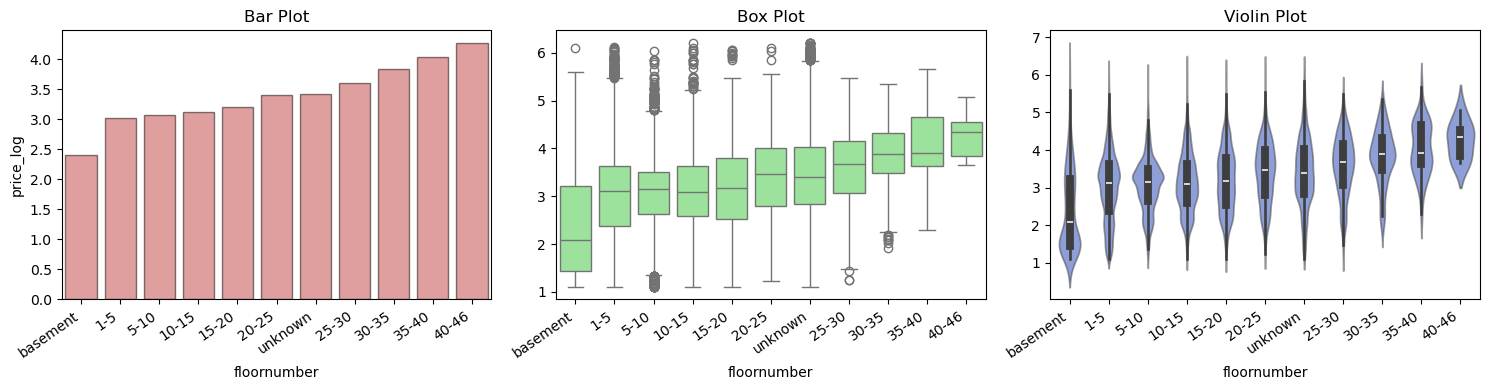

In [99]:
import numpy as np
import pandas as pd

df = df.copy()

# 1. Normalize textual floor labels to numeric
df['floornumber'] = (
    df['floornumber']
    .replace('Lower Basement', -1)
    .replace('Upper Basement', -2)
    .replace('Ground Floor', 0)
)

# 2. Attempt to convert remaining values to numeric (coerce errors to NaN)
df['floornumber'] = pd.to_numeric(df['floornumber'], errors='coerce')


(
    df.assign(floornumber=lambda df_:(
        np.select([
            df_['floornumber'].between(-2, 0, inclusive='left'),  # -2 <= x < 0
            df_['floornumber'].between(1, 5, inclusive='left'),   # 1 <= x < 5
            df_['floornumber'].between(5, 10, inclusive='left'),  # 5 <= x < 10
            df_['floornumber'].between(10, 15, inclusive='left'),
            df_['floornumber'].between(15, 20, inclusive='left'),
            df_['floornumber'].between(20, 25, inclusive='left'),
            df_['floornumber'].between(25, 30, inclusive='left'),
            df_['floornumber'].between(30, 35, inclusive='left'),
            df_['floornumber'].between(35, 40, inclusive='left'),
            df_['floornumber'].between(40, 47, inclusive='left')],
            ['basement','1-5','5-10','10-15','15-20','20-25','25-30','30-35','35-40','40-46'],default='unknown')
    )).pipe(eda_helper_functions.num_cat_bivar_plots, 'price_log', 'floornumber')
)

### 7.5 totalfloornumber

In [36]:
eda_helper_functions.num_summary(df, 'totalfloornumber')

0       18.00
1       13.00
2         NaN
3        3.00
4        4.00
         ... 
53964   11.00
53965   14.00
53966     NaN
53967     NaN
53968    3.00
Name: totalfloornumber, Length: 53969, dtype: float64

Data Type      : float64
Missing Data   : 6,020 rows (11.15 %)
Available Data : 47,949 / 53,969 rows


value
percentile       
0            1.00
5            2.00
10           3.00
25           4.00
50           5.00
75          20.00
90          28.00
95          32.00
99          40.00
100         68.00

value
mean                11.91
trimmed mean (5%)     NaN
trimmed mean (10%)    NaN
median               5.00

value
var           110.59
std            10.52
IQR            16.00
mad             3.00
coef_variance   0.88

value
skewness   1.02
kurtosis   0.04

Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 8.635283002140921e-110
Test Statistic       : 0.8299011785818486
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 3302.5406639167268
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


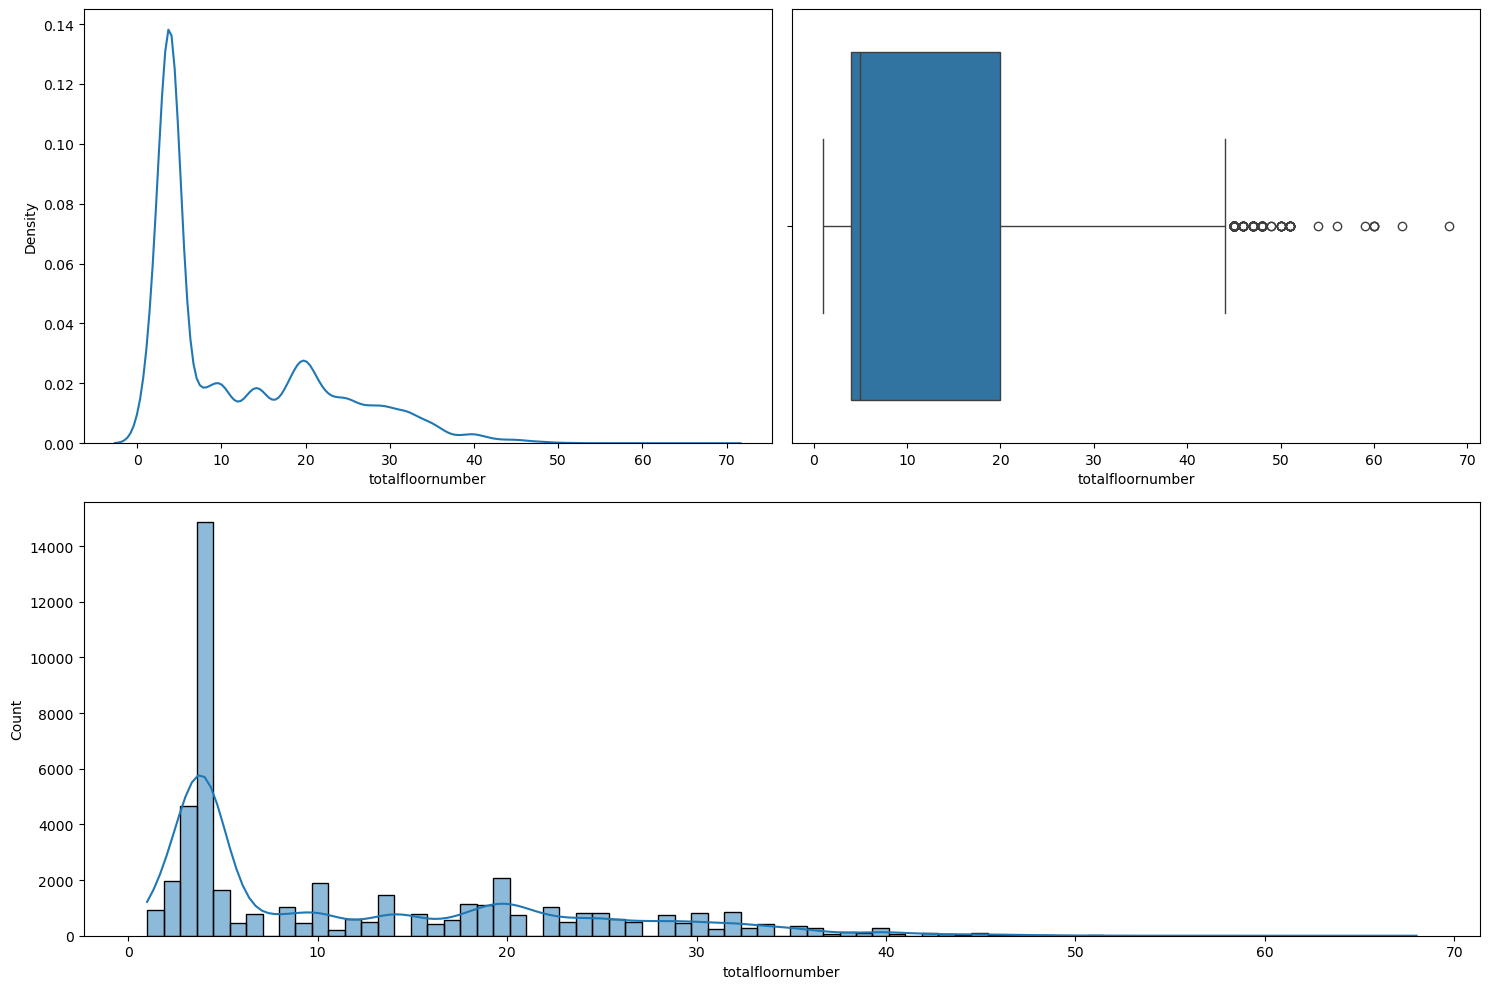

In [37]:
eda_helper_functions.numerical_analysis(df, 'totalfloornumber')

#### observations:
- The totalfloornumber column contains discrete values.
- There are some extreme values present that are irrelevant because the maximum number of floors built in New Delhi, Gurgaon, Noida, and Greater Noida are 48, 61, 68, and 68, respectively. Therefore, we need to remove those values.

### 7.6 transactiontype

In [38]:
eda_helper_functions.cat_summary(df, 'transactiontype')

0              resale
1        new property
2              resale
3              resale
4              resale
             ...     
53964    new property
53965    new property
53966          resale
53967          resale
53968          resale
Name: transactiontype, Length: 53969, dtype: object

Data Type      : object
Cardinality    : 2 categories
Missing Data   : 4 rows (0.01 %)
Available Data : 53,965 / 53,969 rows


count    53965
unique       2
top     resale
freq     34892

count  percentage
category                       
resale        34892        0.65
new property  19073        0.35

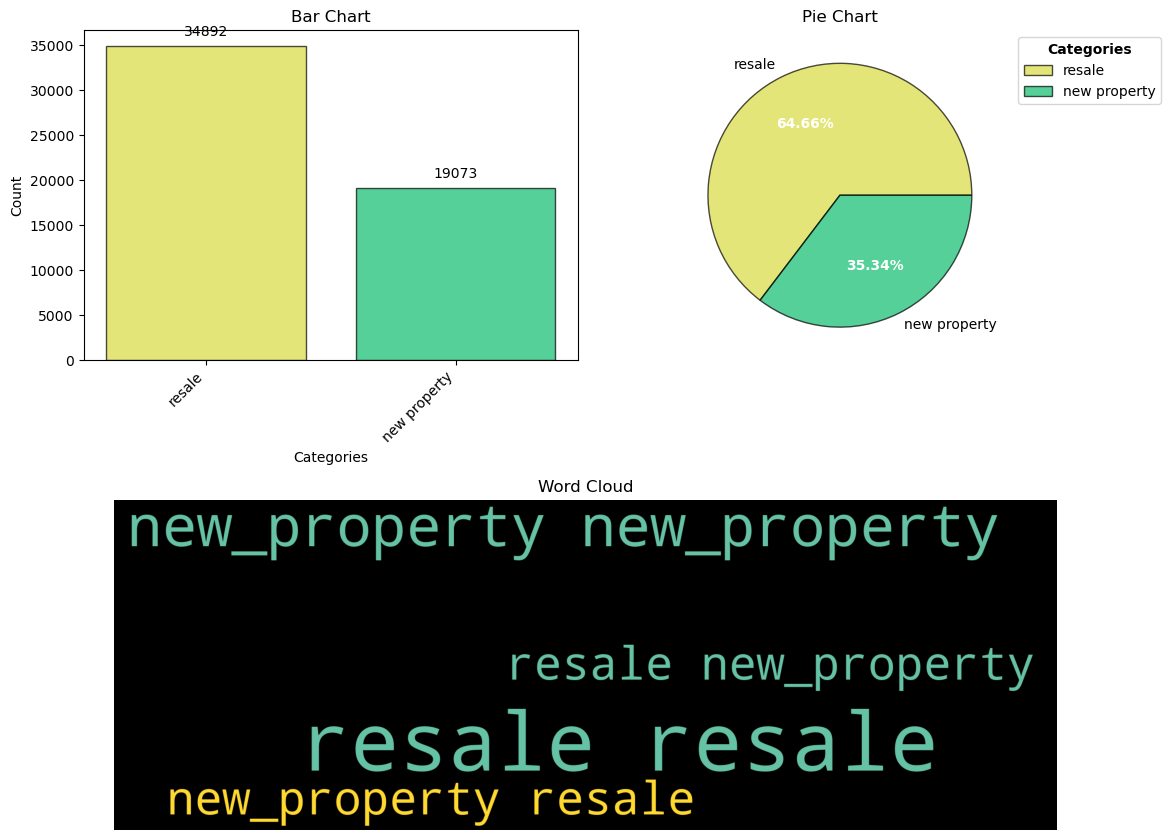

In [39]:
eda_helper_functions.cat_univar_plots(df,'transactiontype')

In [103]:
eda_helper_functions.num_cat_bivar_plots(df, 'price_log', 'transactiontype')

In [104]:
eda_helper_functions.num_cat_hyp_testing(df, 'price_log', 'transactiontype')

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 677.1431876229628
- p-value              : 2.3109719672092298e-148
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price_log and transactiontype are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 791.7641978191712
- p-value              : 3.33184122303656e-174
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price_log and transactiontype are associated to each other


### 7.7 facing

In [40]:
eda_helper_functions.cat_summary(df, 'facing')

0        north - east
1                east
2                 NaN
3        north - east
4        north - east
             ...     
53964            east
53965            east
53966             NaN
53967             NaN
53968            east
Name: facing, Length: 53969, dtype: object

Data Type      : object
Cardinality    : 10 categories
Missing Data   : 16,023 rows (29.69 %)
Available Data : 37,946 / 53,969 rows


count          37946
unique            10
top     north - east
freq           17150

count  percentage
category                       
north - east  17150        0.45
east          11306        0.30
north          4631        0.12
north - west   1742        0.05
west           1042        0.03
south - east    933        0.02
south           626        0.02
south -west     513        0.01
east facing       2        0.00
north facing      1        0.00

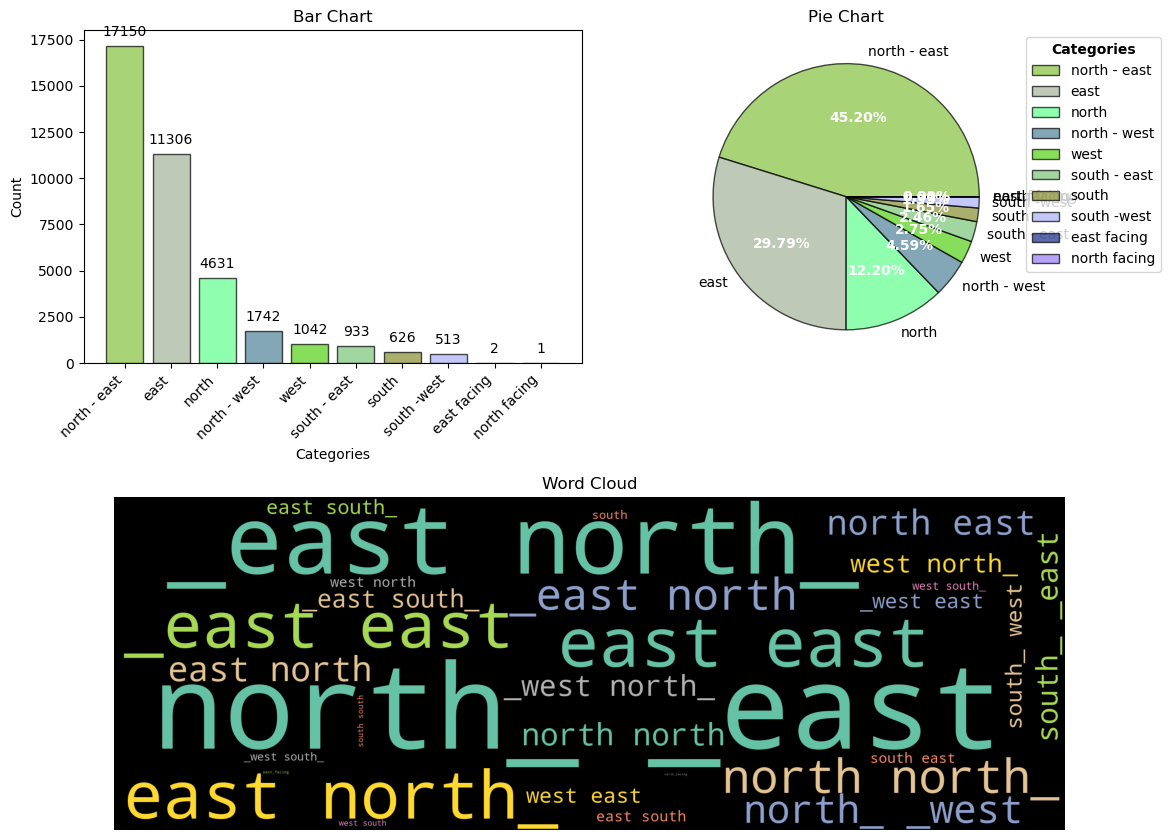

In [41]:
eda_helper_functions.cat_univar_plots(df,'facing')

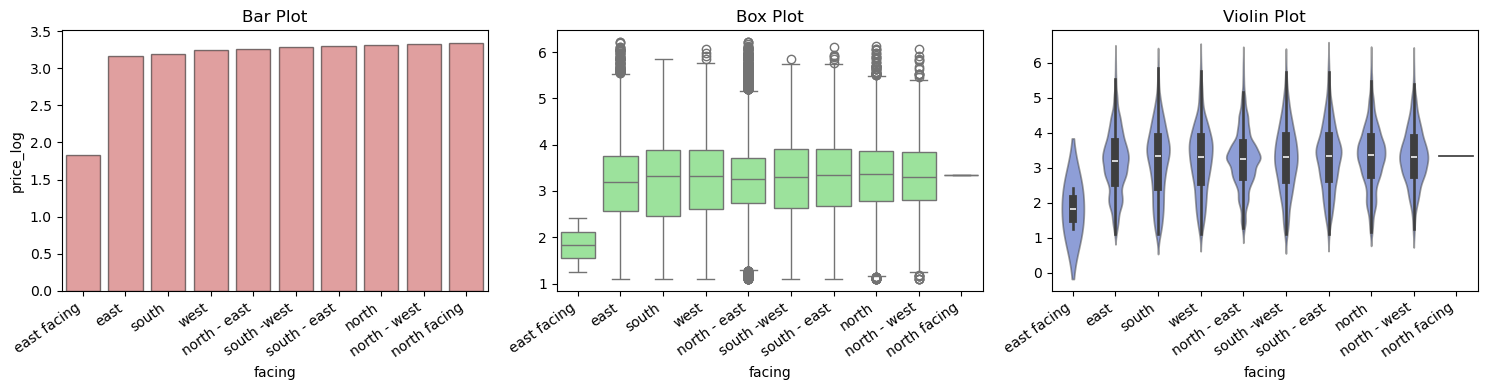

In [105]:
eda_helper_functions.num_cat_bivar_plots(df, 'price_log', 'facing')

### 7.8 ownershiptype

In [42]:
eda_helper_functions.cat_summary(df, 'ownershiptype')

0        leasehold
1         freehold
2        leasehold
3        leasehold
4         freehold
           ...    
53964     freehold
53965     freehold
53966     freehold
53967     freehold
53968     freehold
Name: ownershiptype, Length: 53969, dtype: object

Data Type      : object
Cardinality    : 4 categories
Missing Data   : 14,682 rows (27.20 %)
Available Data : 39,287 / 53,969 rows


count      39287
unique         4
top     freehold
freq       29433

count  percentage
category                               
freehold              29433        0.75
leasehold              9121        0.23
power of attorney       421        0.01
co-operative society    312        0.01

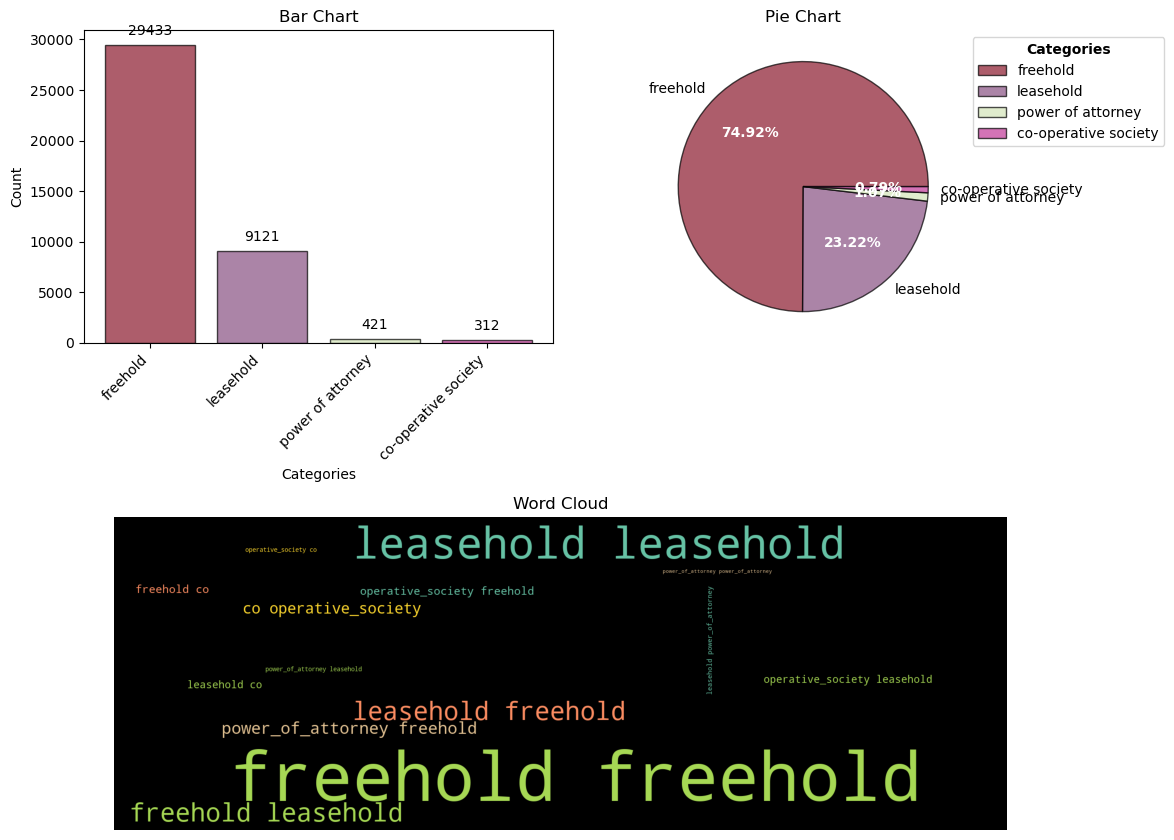

In [43]:
eda_helper_functions.cat_univar_plots(df, 'ownershiptype')

In [106]:
eda_helper_functions.num_cat_bivar_plots(df, 'price_log', 'ownershiptype')

In [109]:
eda_helper_functions.num_cat_hyp_testing(df, 'price_log', 'ownershiptype')

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 397.51229616181024
- p-value              : 2.141991865881653e-254
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price_log and ownershiptype are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 1418.1425913055286
- p-value              : 3.406865216629207e-307
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price_log and ownershiptype are associated to each other


### 7.9 furnished

In [44]:
eda_helper_functions.cat_summary(df,'furnished')

0             furnished
1             furnished
2        semi-furnished
3           unfurnished
4           unfurnished
              ...      
53964    semi-furnished
53965    semi-furnished
53966    semi-furnished
53967       unfurnished
53968    semi-furnished
Name: furnished, Length: 53969, dtype: object

Data Type      : object
Cardinality    : 3 categories
Missing Data   : 790 rows (1.46 %)
Available Data : 53,179 / 53,969 rows


count            53179
unique               3
top     semi-furnished
freq             33037

count  percentage
category                         
semi-furnished  33037        0.62
unfurnished     14831        0.28
furnished        5311        0.10

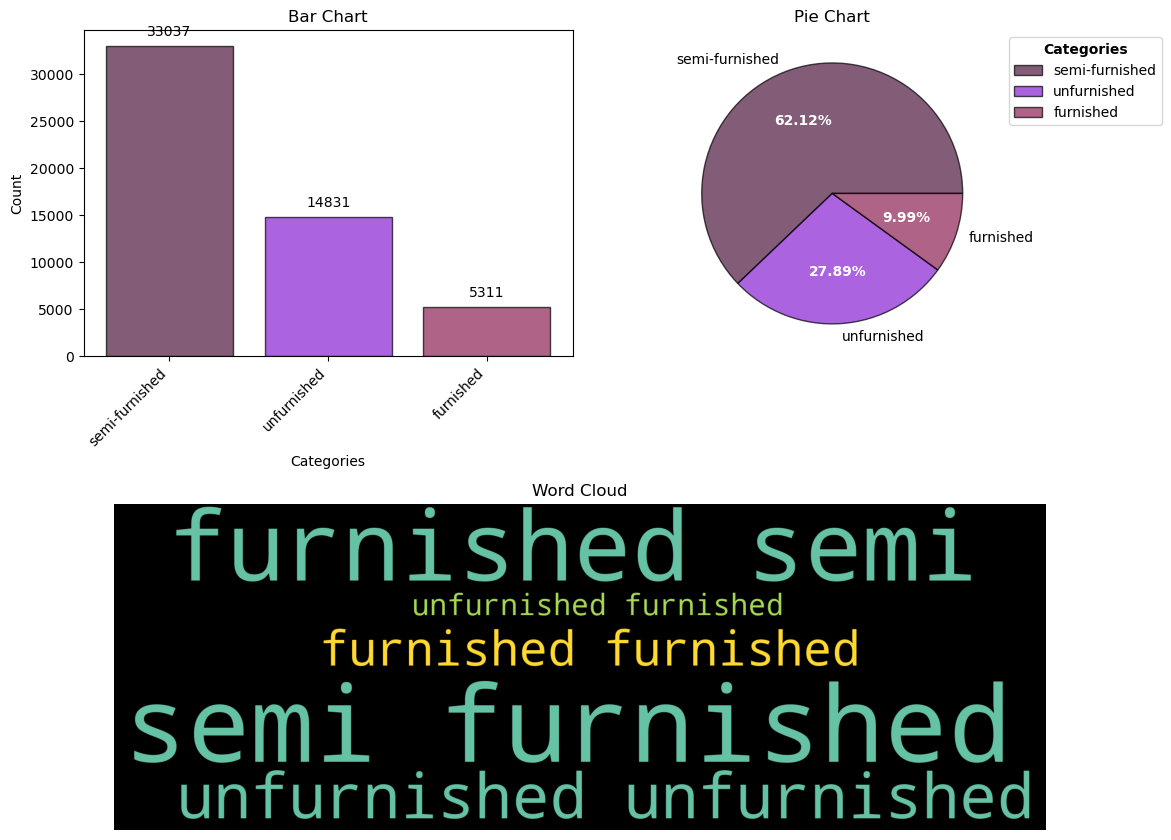

In [45]:
eda_helper_functions.cat_univar_plots(df, 'furnished')

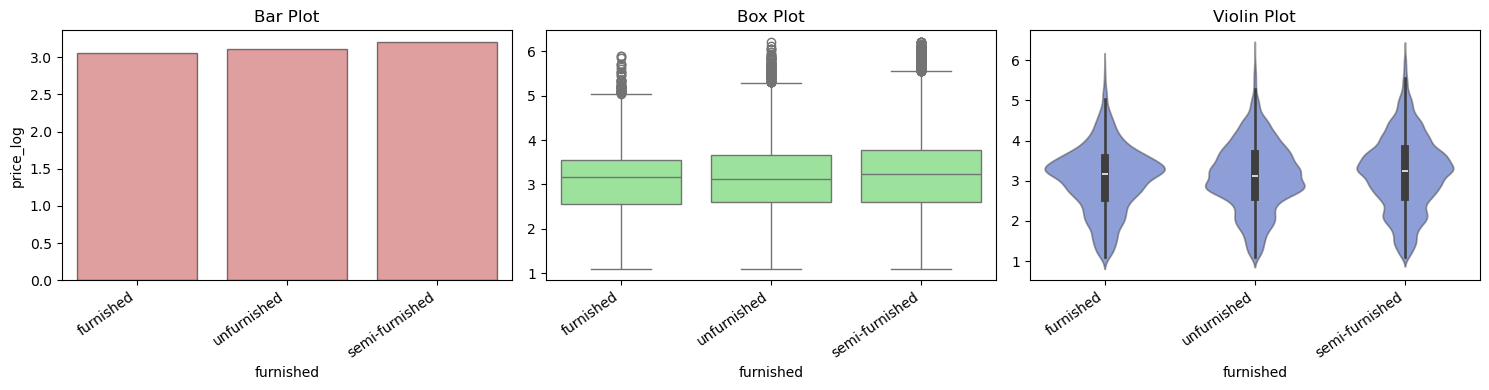

In [110]:
eda_helper_functions.num_cat_bivar_plots(df, 'price_log', 'furnished')

In [112]:
eda_helper_functions.num_cat_hyp_testing(df, 'price_log', 'furnished')

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 99.74839373502988
- p-value              : 5.766084931258991e-44
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price_log and furnished are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 192.97698632386474
- p-value              : 1.2461773476416186e-42
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price_log and furnished are associated to each other


In [117]:
eda_helper_functions.numerical_numerical_col_analysis(df, 'price_log', 'superbuiltupareasqft_log', 'furnished')

### 7.10 bedrooms

In [ ]:
eda_helper_functions.num_summary(df, 'bedrooms')

0       4.00
1       2.00
2       2.00
3       3.00
4       3.00
        ... 
53964   3.00
53965   3.00
53966   5.00
53967   5.00
53968   2.00
Name: bedrooms, Length: 53969, dtype: float64

Data Type      : float64
Missing Data   : 145 rows (0.27 %)
Available Data : 53,824 / 53,969 rows


value
percentile       
0            1.00
5            2.00
10           2.00
25           3.00
50           3.00
75           4.00
90           4.00
95           4.00
99           7.00
100         10.00

value
mean                 3.15
trimmed mean (5%)    3.09
trimmed mean (10%)   3.09
median               3.00

value
var             0.95
std             0.98
IQR             1.00
mad             1.00
coef_variance   0.31

value
skewness   1.60
kurtosis   7.17

Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 1.6199147382356357e-115
Test Statistic       : 0.8106167497474194
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 3312.6554753046003
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


In [47]:
eda_helper_functions.numerical_analysis(df,'bedrooms')

#### observations
- The bedrooms column contains discrete values from 2 to 10.
- There are some extreme values that can be treated as outliers, and these values are significant.
- From my analysis, I found that 3- bedroom and 4-bedroom properties account for 50% and 24% of the data, respectively, making up a total of 74%. This mean that other hold less than 26%, indicating that 3-bedroom and 4-bedroom flats, villas, and residential properties are the most commonly purchased by customers, followed by 2-bedroom properties, 5-bedroom properties etc.

In [113]:
eda_helper_functions.num_cat_bivar_plots(df, 'price_log', 'bedrooms')

In [114]:
eda_helper_functions.num_cat_hyp_testing(df, 'price_log', 'bedrooms')

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 4407.9695166514775
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price_log and bedrooms are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 23209.754198928615
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price_log and bedrooms are associated to each other


In [119]:
eda_helper_functions.numerical_numerical_col_analysis(df, 'price_log', 'superbuiltupareasqft_log', 'bedrooms')

In [122]:
eda_helper_functions.hyp_cat_cat(df,'bedrooms','furnished')

- Cramers V            : 0.05284429797063572
- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 314.24201257127885
- p-value              : 5.624822779078395e-56
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables bedrooms and furnished are correlated


In [120]:
eda_helper_functions.multivariate_analysis(df, 'price_log','bedrooms','furnished')

### 7.11 bathrooms

In [48]:
eda_helper_functions.num_summary(df,'bathrooms')

0       4.00
1       2.00
2       2.00
3       3.00
4       3.00
        ... 
53964   3.00
53965   2.00
53966   5.00
53967   7.00
53968   3.00
Name: bathrooms, Length: 53969, dtype: float64

Data Type      : float64
Missing Data   : 168 rows (0.31 %)
Available Data : 53,801 / 53,969 rows


value
percentile       
0            1.00
5            2.00
10           2.00
25           2.00
50           3.00
75           4.00
90           5.00
95           5.00
99           7.00
100         10.00

value
mean                 3.09
trimmed mean (5%)    3.03
trimmed mean (10%)   2.97
median               3.00

value
var             1.34
std             1.16
IQR             2.00
mad             1.00
coef_variance   0.37

value
skewness   1.14
kurtosis   2.91

Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 7.008643327342884e-105
Test Statistic       : 0.8724052747661198
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 2337.6794295828004
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


In [49]:
eda_helper_functions.numerical_analysis(df,'bathrooms')

#### observations
- The bathrooms column contains discrete values from 2 to 10.
- There are some extreme values that can be treated as outliers, and these values are significant.

### 7.12 numberofbalconied

In [50]:
eda_helper_functions.num_summary(df, 'numberofbalconied')

0        NaN
1       2.00
2        NaN
3       2.00
4       1.00
        ... 
53964   3.00
53965   2.00
53966    NaN
53967    NaN
53968   2.00
Name: numberofbalconied, Length: 53969, dtype: float64

Data Type      : float64
Missing Data   : 6,262 rows (11.60 %)
Available Data : 47,707 / 53,969 rows


value
percentile       
0            1.00
5            1.00
10           1.00
25           2.00
50           3.00
75           3.00
90           4.00
95           5.00
99           6.00
100         10.00

value
mean                 2.78
trimmed mean (5%)     NaN
trimmed mean (10%)    NaN
median               3.00

value
var             1.28
std             1.13
IQR             1.00
mad             1.00
coef_variance   0.41

value
skewness   0.58
kurtosis   1.27

Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 1.7583981291988738e-93
Test Statistic       : 0.9092855399669586
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 1614.95239661495
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


In [51]:
eda_helper_functions.numerical_analysis(df,'numberofbalconied')

#### observations
- The numberofbalconied column contains discrete values from 2 to 10.
- There are some extreme values that can be treated as outliers, and these values are significant.

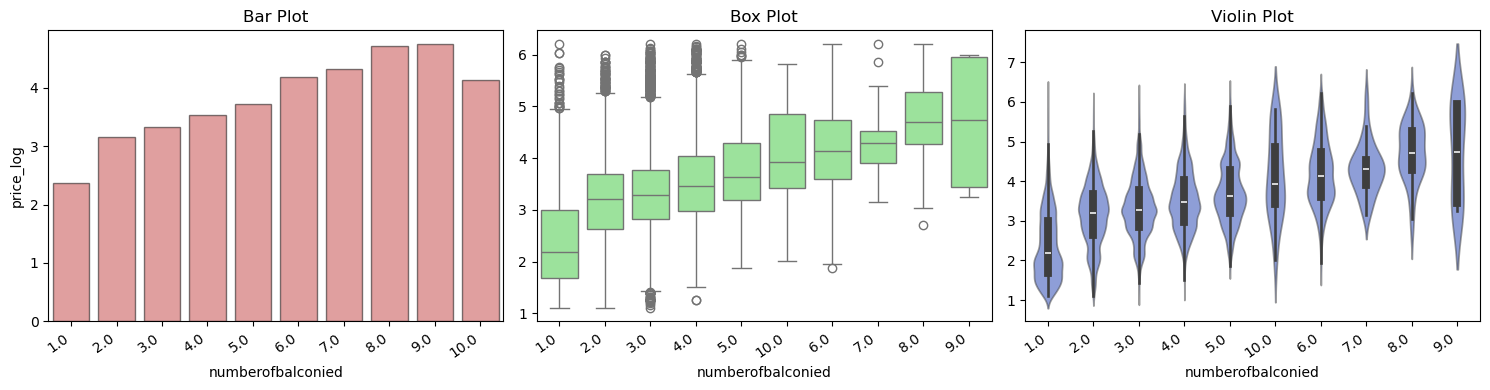

In [124]:
eda_helper_functions.num_cat_bivar_plots(df, 'price_log', 'numberofbalconied')

In [125]:
eda_helper_functions.num_cat_hyp_testing(df, 'price_log', 'numberofbalconied')

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 1185.003097137288
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price_log and numberofbalconied are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 7337.193870424248
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price_log and numberofbalconied are associated to each other


### 7.13 propertytype

In [52]:
eda_helper_functions.cat_summary(df, 'propertytype')

0          multistorey apartment
1          multistorey apartment
2          multistorey apartment
3          multistorey apartment
4        builder floor apartment
                  ...           
53964      multistorey apartment
53965      multistorey apartment
53966      multistorey apartment
53967          residential house
53968    builder floor apartment
Name: propertytype, Length: 53969, dtype: object

Data Type      : object
Cardinality    : 5 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 53,969 / 53,969 rows


count                   53969
unique                      5
top     multistorey apartment
freq                    34847

count  percentage
category                                  
multistorey apartment    34847        0.65
builder floor apartment  14668        0.27
residential house         2974        0.06
villa                     1278        0.02
penthouse                  202        0.00

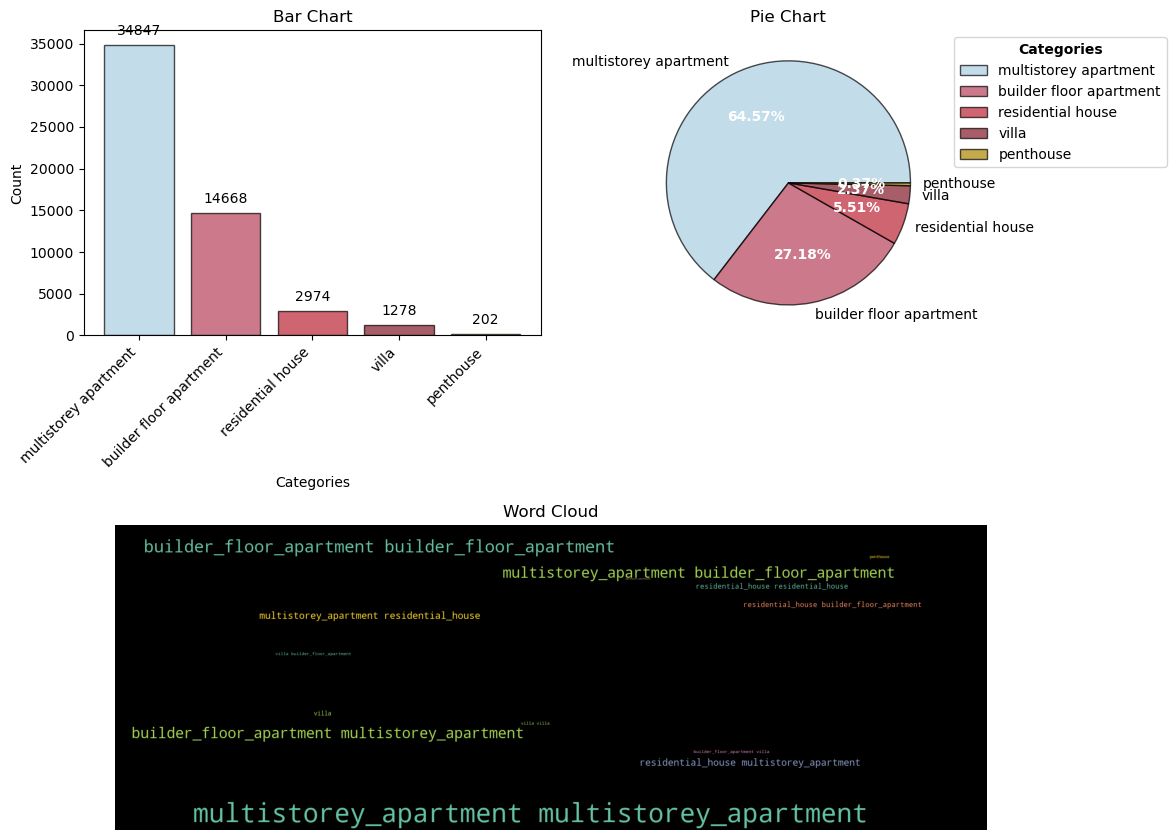

In [53]:
eda_helper_functions.cat_univar_plots(df,'propertytype')

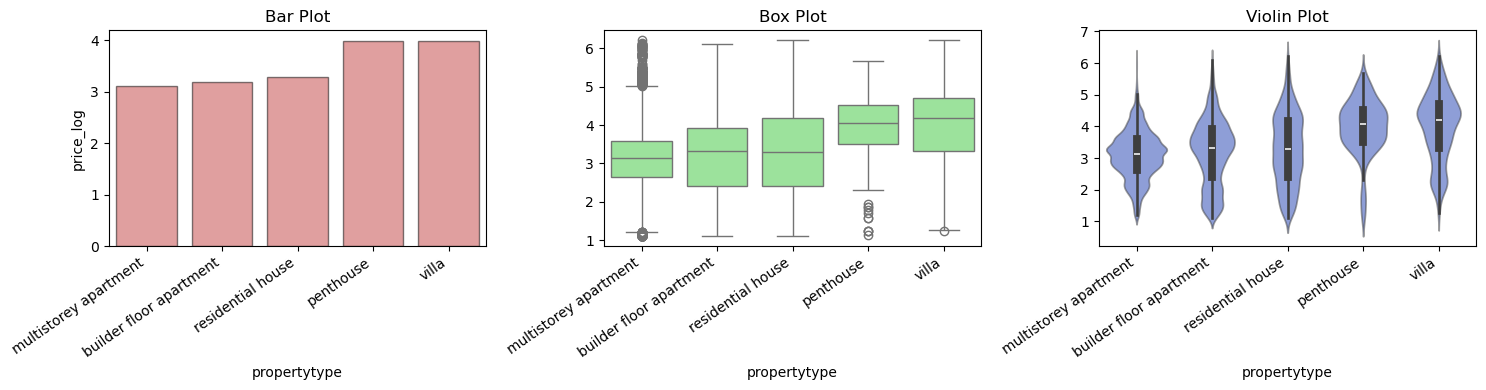

In [126]:
eda_helper_functions.num_cat_bivar_plots(df, 'price_log', 'propertytype')

In [127]:
eda_helper_functions.num_cat_hyp_testing(df, 'price_log', 'propertytype')

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 386.8827270888524
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price_log and propertytype are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 1271.4510682305881
- p-value              : 5.150635242534338e-274
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price_log and propertytype are associated to each other


In [138]:
eda_helper_functions.multivariate_analysis(df, 'price_log', 'propertytype', 'furnished')

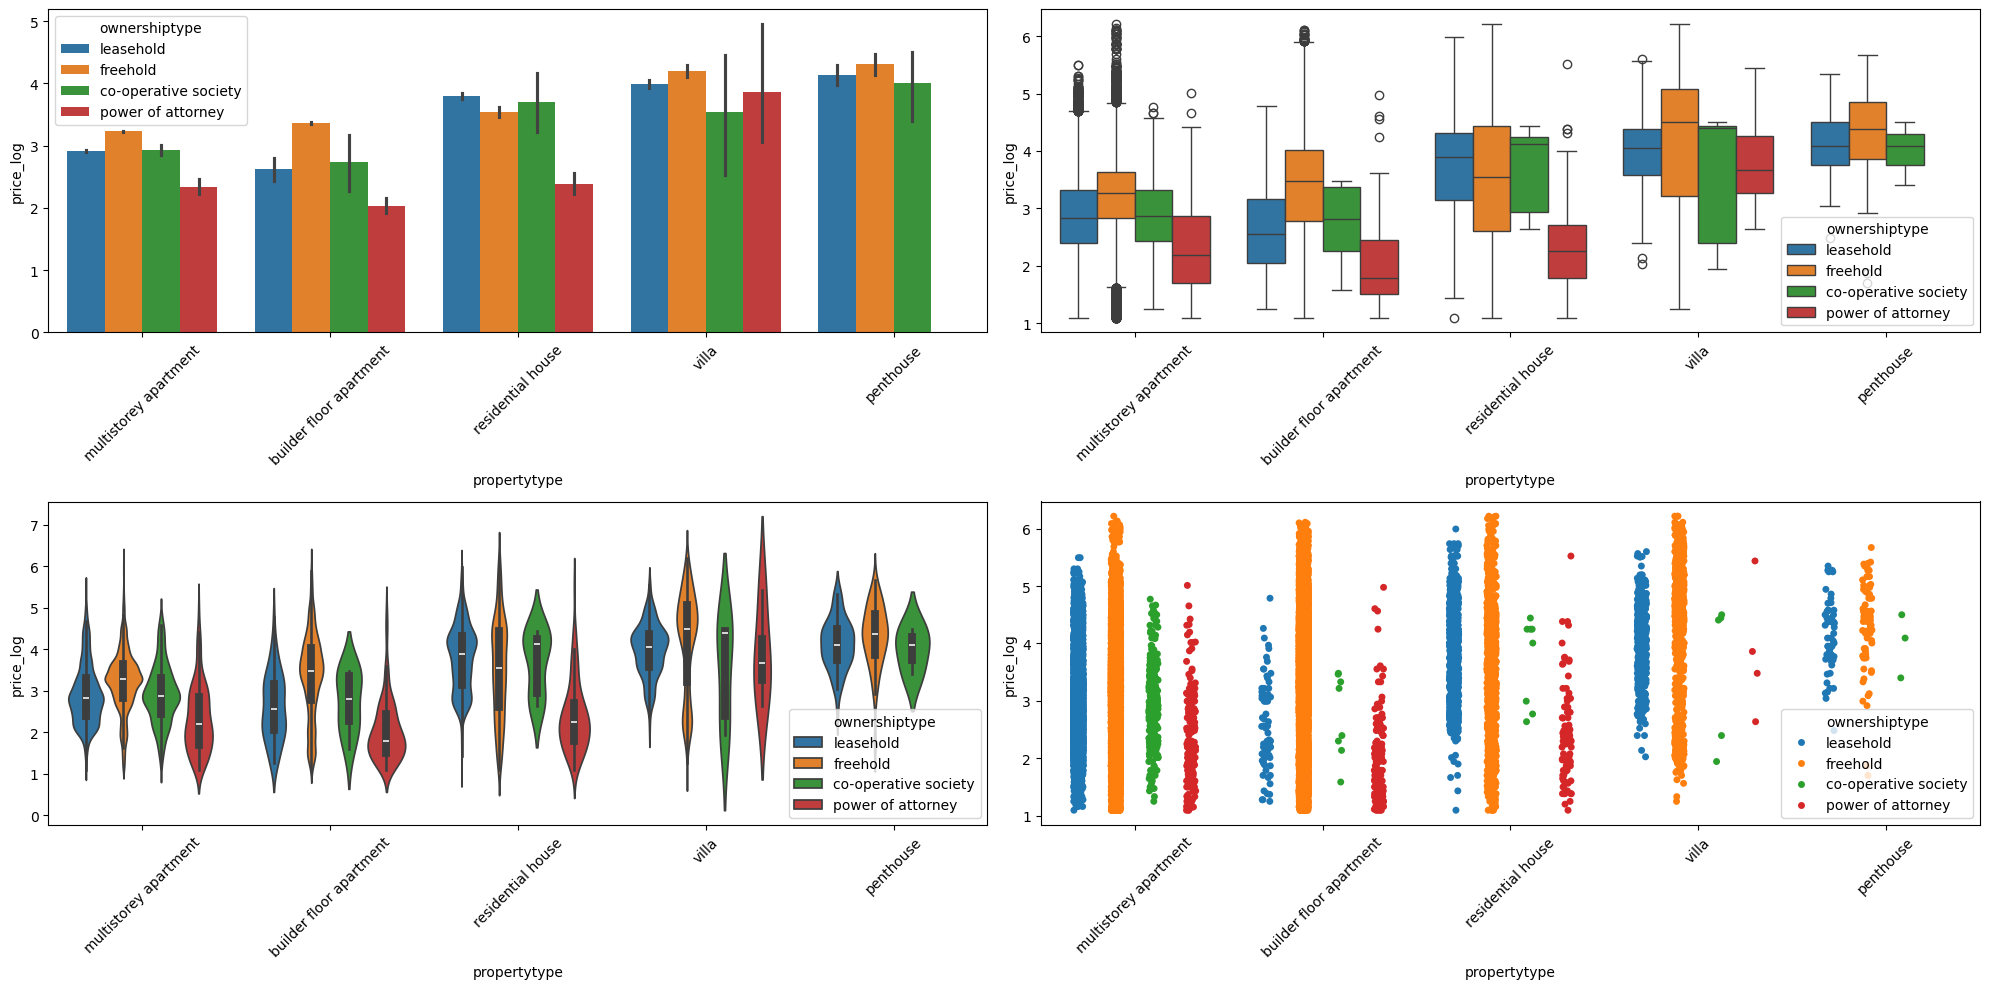

In [141]:
eda_helper_functions.multivariate_analysis(df, 'price_log', 'propertytype', 'ownershiptype')

In [144]:
eda_helper_functions.hyp_cat_cat(df, 'propertytype', 'ownershiptype')

- Cramers V            : 0.21370487723655854
- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 5394.274565809496
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables propertytype and ownershiptype are correlated


In [145]:
eda_helper_functions.hyp_cat_cat(df, 'propertytype', 'furnished')

- Cramers V            : 0.09633755438789167
- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 995.0635818291328
- p-value              : 1.7362857762864522e-209
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables propertytype and furnished are correlated


### 7.14 additionalrooms

In [54]:
eda_helper_functions.cat_summary(df, 'additionalrooms')

0               puja room, store, servant room
1                                        study
2                                          NaN
3        puja room, study, store, servant room
4                                    puja room
                         ...                  
53964                                      NaN
53965                                      NaN
53966                                      NaN
53967                             servant room
53968                                      NaN
Name: additionalrooms, Length: 53969, dtype: object

Data Type      : object
Cardinality    : 63 categories
Missing Data   : 20,093 rows (37.23 %)
Available Data : 33,876 / 53,969 rows


count          33876
unique            63
top     servant room
freq            6968

count  percentage
category                                                             
servant room                                         6968        0.21
none of these                                        6249        0.18
store                                                3278        0.10
puja room, study, store, servant room                2954        0.09
puja room                                            2930        0.09
study                                                2808        0.08
puja room, servant room                              1759        0.05
store, servant room                                  1040        0.03
puja room, store, servant room                        994        0.03
puja room, store                                      964        0.03
study, servant room                                   805        0.02
puja room, store, study, servant room                 633        0.02
puja room, study                                      574        0.02
puja room, study, store                               508        0.01
puja room, study, servant room                        454        0.01
study, store                                          318        0.01
study, store, servant room                            225        0.01
puja room, store, study                                65        0.00
store, study                                           61        0.00
puja room, study, servant room, store                  43        0.00
servant room, store                                    27        0.00
store, study, servant room                             23        0.00
servant room, puja room                                20        0.00
study, puja room, servant room, store                  14        0.00
puja room, store, servant room, study                  14        0.00
puja room, servant room, store, study                  12        0.00
study, servant room, store, puja room                  11        0.00
puja room, servant room, store                         10        0.00
store, puja room, study, servant room                   9        0.00
study, puja room                                        9        0.00
study, puja room, store, servant room                   9        0.00
study, store, servant room, puja room                   6        0.00
store, puja room                                        6        0.00
study, store, puja room                                 5        0.00
study, servant room, puja room, store                   5        0.00
servant room, study                                     4        0.00
store, servant room, puja room, study                   4        0.00
study, puja room, servant room                          4        0.00
store, servant room, puja room                          4        0.00
store, study, servant room, puja room                   4        0.00
servant room, study, store, puja room                   3        0.00
puja room, servant room, study                          3        0.00
store, puja room, servant room                          3        0.00
servant room, study, puja room                          3        0.00
store, none of these                                    3        0.00
store, puja room, servant room, study                   3        0.00
store, servant room, study                              3        0.00
servant room, store, study                              2        0.00
study, servant room, puja room                          2        0.00
store, servant room, study, puja room                   2        0.00
study, store, puja room, servant room                   2        0.00
servant room, study, puja room, store                   2        0.00
servant room, store, puja room, study                   2        0.00
store, puja room, study                                 2        0.00
puja room, servant room, study, store                   2        0.00
study, servant room, store                              2     

#### observations:
- There are 33,876 rows available and 20,093 missing values. Based on my observation, we should convert this column into a binary format — for example, 1 for additional room availability and 0 for no availability. In this way, we can retain this column. Also, there is a 'none of these' category with 6,249 rows, which we can also convert to 0 (no availability).

### 7.15 ageofcons


In [55]:
eda_helper_functions.cat_summary(df,'ageofcons')

0                       NaN
1         less than 5 years
2                       NaN
3            15 to 20 years
4                       NaN
                ...        
53964    under construction
53965    under construction
53966                   NaN
53967    under construction
53968                   NaN
Name: ageofcons, Length: 53969, dtype: object

Data Type      : object
Cardinality    : 7 categories
Missing Data   : 6,373 rows (11.81 %)
Available Data : 47,596 / 53,969 rows


count              47596
unique                 7
top     new construction
freq               13558

count  percentage
category                             
new construction    13558        0.28
less than 5 years    9533        0.20
under construction   9134        0.19
5 to 10 years        8214        0.17
10 to 15 years       3806        0.08
15 to 20 years       2296        0.05
above 20 years       1055        0.02

In [56]:
eda_helper_functions.cat_univar_plots(df, 'ageofcons')

In [142]:
eda_helper_functions.num_cat_bivar_plots(df, 'price_log', 'ageofcons')

In [143]:
eda_helper_functions.num_cat_hyp_testing(df, 'price_log', 'ageofcons')

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 137.83363471473393
- p-value              : 7.594311566196222e-174
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price_log and ageofcons are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 957.860285465644
- p-value              : 1.160405392798283e-203
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price_log and ageofcons are associated to each other


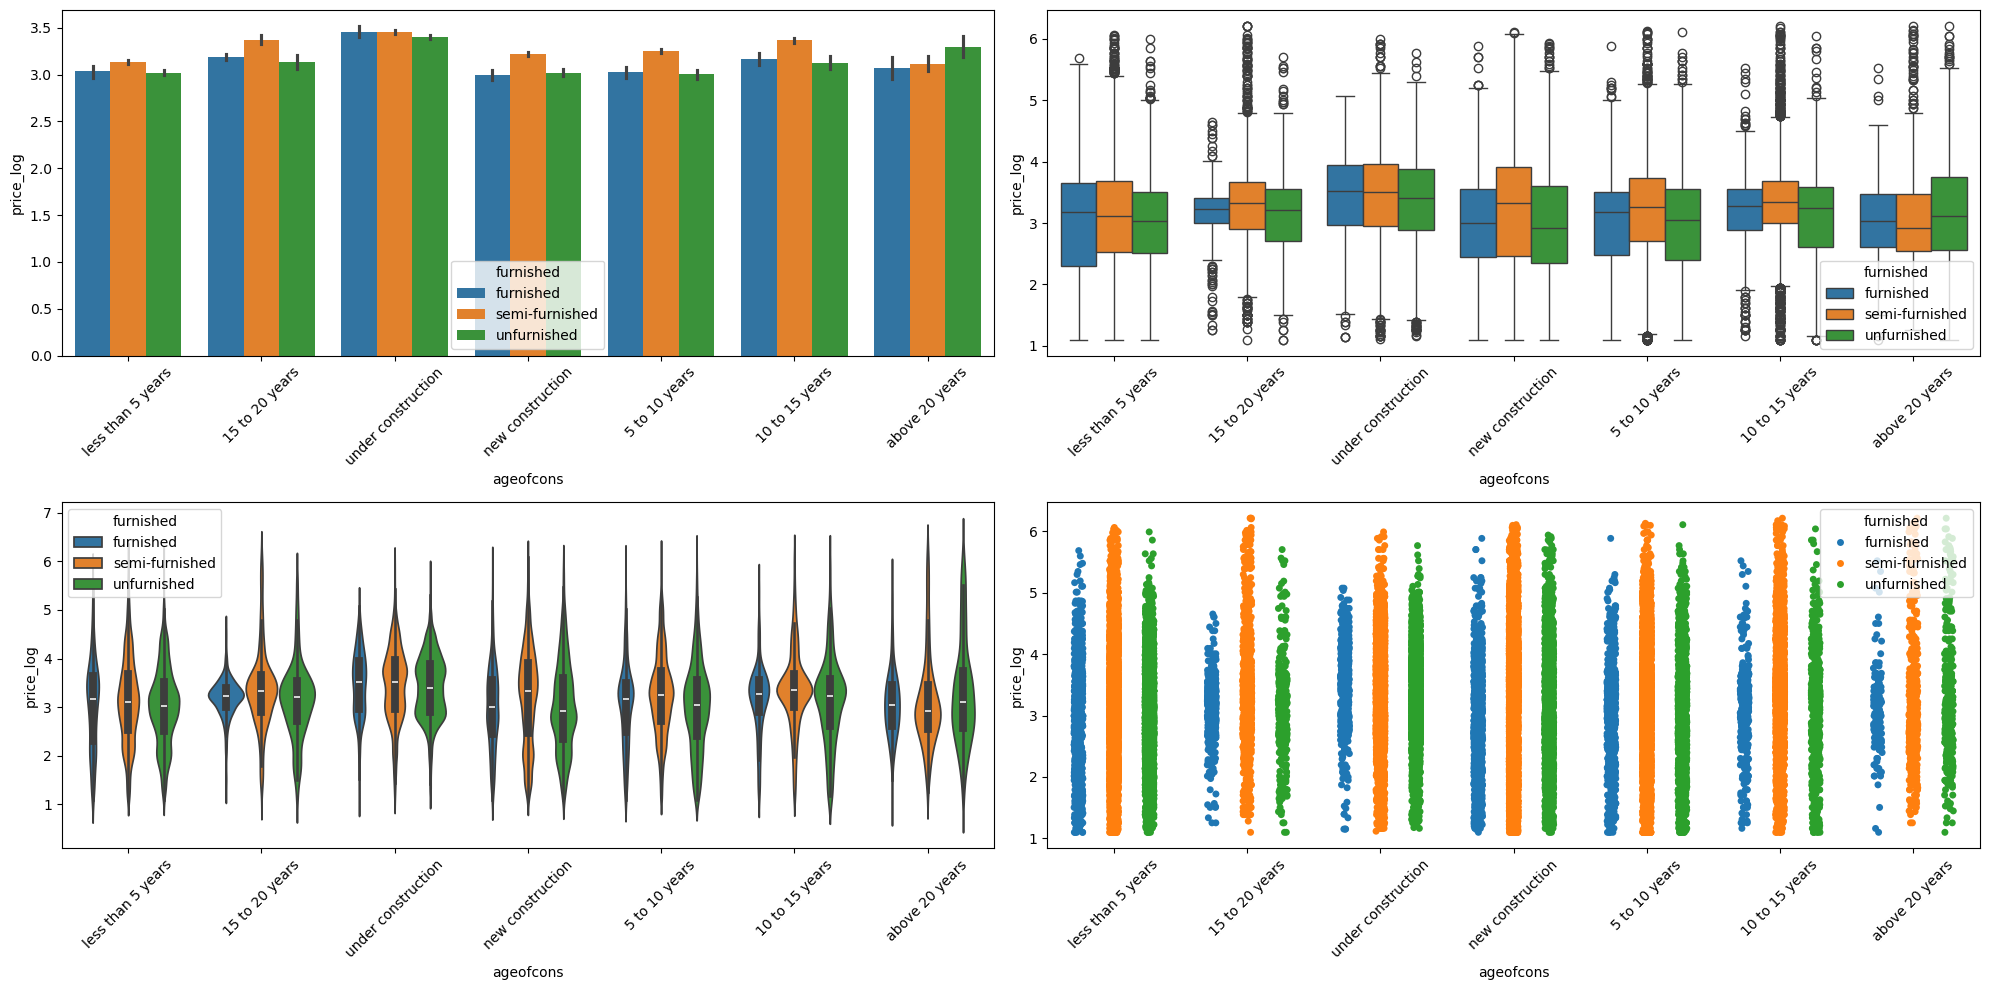

In [146]:
eda_helper_functions.multivariate_analysis(df, 'price_log', 'ageofcons', 'furnished')

### 7.16 region

In [57]:
eda_helper_functions.cat_summary(df,'region')

0          noida
1          noida
2          noida
3          noida
4          noida
          ...   
53964    gurgaon
53965    gurgaon
53966    gurgaon
53967    gurgaon
53968    gurgaon
Name: region, Length: 53969, dtype: object

Data Type      : object
Cardinality    : 4 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 53,969 / 53,969 rows


count     53969
unique        4
top     gurgaon
freq      21434

count  percentage
category                       
gurgaon       21434        0.40
delhi         16473        0.31
noida          8068        0.15
greaterNoida   7994        0.15

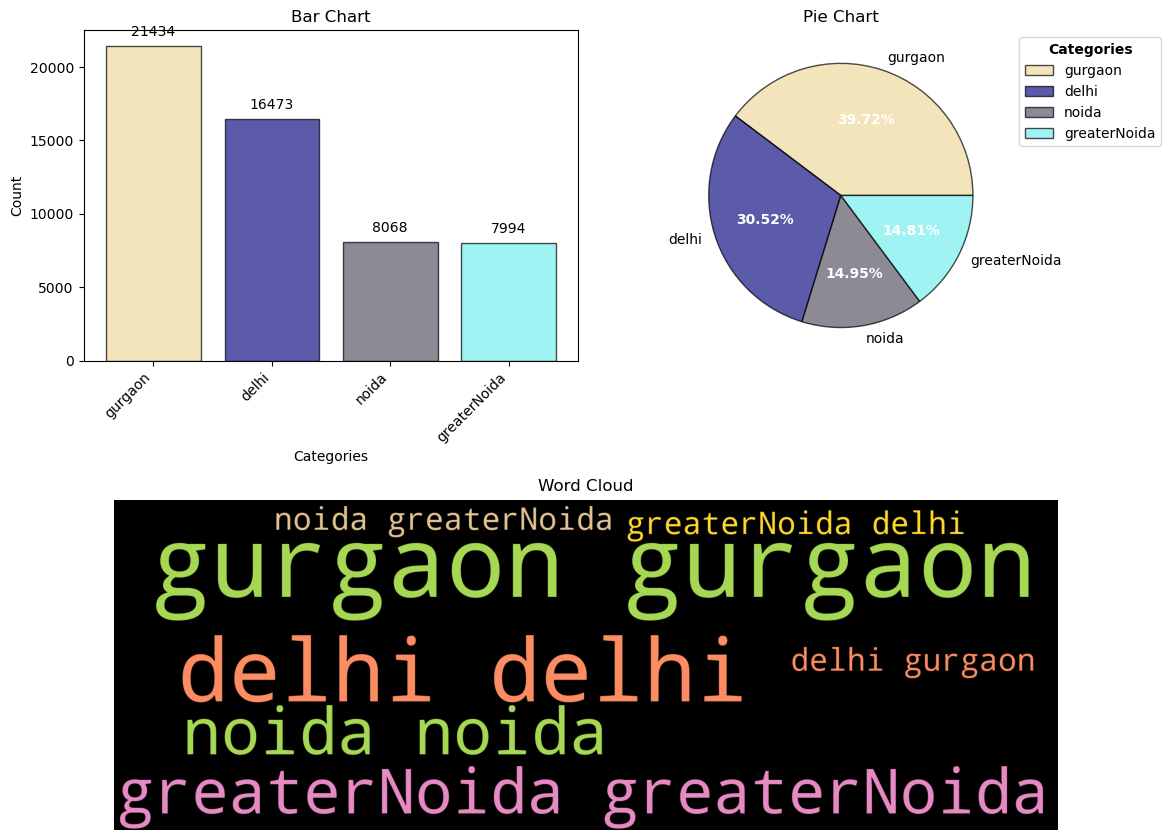

In [58]:
eda_helper_functions.cat_univar_plots(df, 'region')

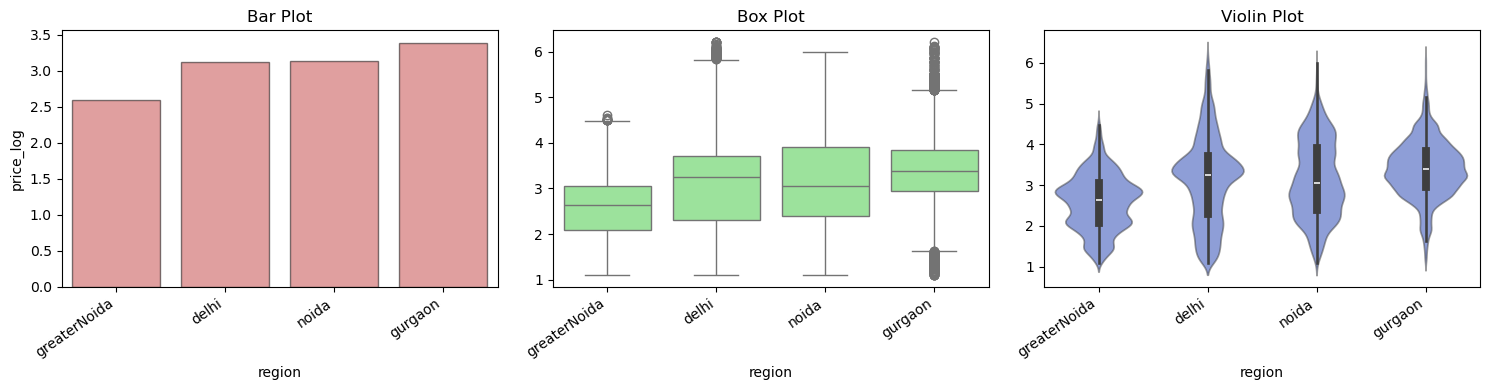

In [147]:
eda_helper_functions.num_cat_bivar_plots(df, 'price_log', 'region')

## 8 Automated EDA

In [148]:
from ydata_profiling import ProfileReport

In [149]:
report = ProfileReport(df)
report.to_file(output_file='eda_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:06<00:00,  4.30it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]